# Apply AI Superresolution to video - Train VDSR from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.






## Share results
- put out an example on youtube to allow comparison


# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "VDNEW2"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train vdsr with hres perception loss multifuz mish.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train vdsr with hres perception loss multifuz mish.ipynb
/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz mish


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage

import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp"])



In [10]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [11]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data/train_data",1)

In [12]:
instances

[{'Filepath': '/media/SSD/superres/video_data/train_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/train_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/train_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/train_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/train_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/train_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/train_data/102797996.mp4',
  'Type': 'frame',
  'F

In [13]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [14]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [15]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        if self.size is not None:
            input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [20]:
def tophat2D(r):
    
    d=2*int(r)+1
    Y, X = np.ogrid[:d, :d]
    c=int(r)
    k = (np.sqrt((X-c)**2 +  (Y-c)**2) <= r)*1 
    
    return k/k.sum()

    
    

In [16]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [60]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, tophat2D(rand_scale_factor))
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [61]:
class Crappify(object):


    def __init__(self, crop_size ,kernel_size, quality):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_size = kernel_size
        self.quality = quality

    
        

    def __call__(self, img):
        
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        
        k=tophat2D(int(self.kernel_size)/2.0)
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        if self.crop_size is not None:
            img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,self.quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [19]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [21]:
tophat2D(2)

array([[0.        , 0.        , 0.07692308, 0.        , 0.        ],
       [0.        , 0.07692308, 0.07692308, 0.07692308, 0.        ],
       [0.07692308, 0.07692308, 0.07692308, 0.07692308, 0.07692308],
       [0.        , 0.07692308, 0.07692308, 0.07692308, 0.        ],
       [0.        , 0.        , 0.07692308, 0.        , 0.        ]])

In [22]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(self.crop_size[0],self.crop_size[1])
        
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        rand_center = (random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel A
        
        k = tophat2D(int(rand_kernel)/2.0)
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #blur kernel B
        rand_kernel = random.uniform(*self.kernel_range)
        k = tophat2D(int(rand_kernel)/2.0)
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, slope=rand_slope,center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        #img_cv = img_cv_blurA
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,rand_quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (720, 480)


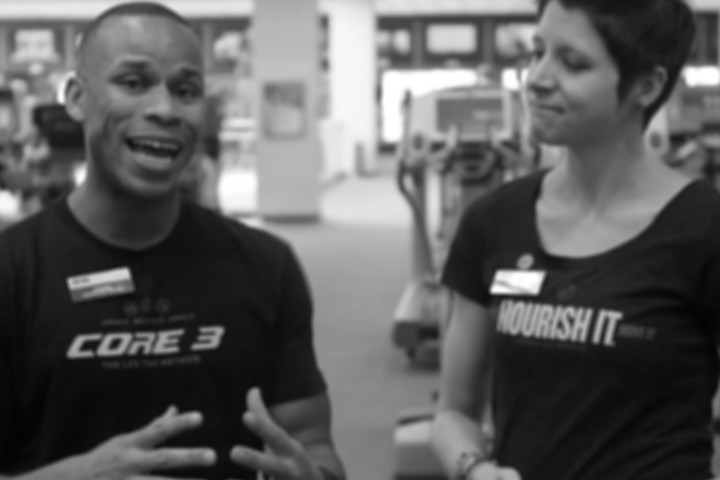

In [23]:
#test the CropRescale transform
im=load_frame(instances[10])
im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (480,720),
                  kernel_range=(1,10), 
                  quality_range=(90,90), 
                  slope_range=(0.0001, 0.1),
                 radius_range=(.05,.5),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [24]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.00001, 0.01),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2)), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])



def test_input_transform(crop_size, kernel_size, quality):
    
    return Compose([
        Crappify(crop_size=crop_size, kernel_size=kernel_size, quality=quality),
        ToTensor()
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, kernel_size, quality, frame_sample_size=10):


    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=test_input_transform(
                                 crop_size, kernel_size, quality),
                             target_transform=ToTensor(),
                             add_noise=None,
                             noise_std=3,Flip_hor=False,
                             Rand_bright_contrast=False)

In [29]:
train_dir = "/media/SSD/superres/video_data/train_data"
frame_sample_size =10
batch_size = 1 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (256,256)
kernel_range=(1,10)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [30]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [31]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(480, 720)


In [32]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [33]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    print(inputs.shape)
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

torch.Size([1, 1, 480, 720])


IndexError: index 1 is out of bounds for axis 0 with size 1

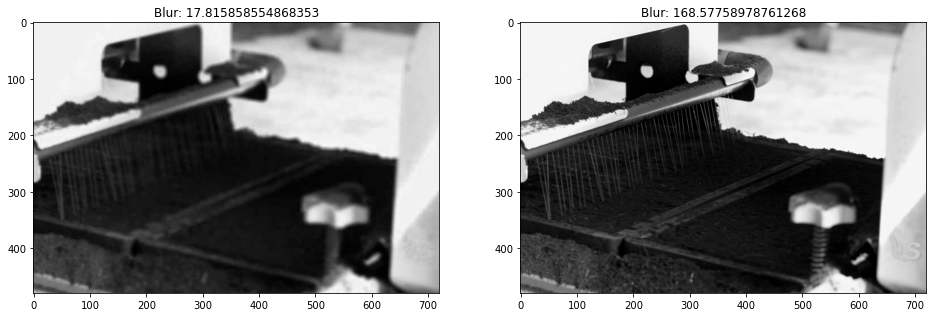

In [34]:
show_batch(training_data_loader,size =8)

# VDSR with 3 Channel Color

In [35]:
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from functools import partial

class mish(nn.Module): 
    def __init__(self):
        super(mish, self).__init__()
    def forward(self,x):
        return (x*torch.tanh(F.softplus(x)))

class Conv_ReLU_Block(nn.Module):
    def __init__(self,channels=64):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1, bias=False)
        #self.relu = nn.ReLU(inplace=True)
        self.act = mish()
        
    def forward(self, x):
        return self.act(self.conv(x))


    

class VDSRNet(nn.Module):
    def __init__(self, image_channels=3, blocks=18, feature_channels=64):
        super(VDSRNet, self).__init__()
        self.residual_layer = self.make_layer(partial(Conv_ReLU_Block,channels=feature_channels), blocks)
        self.input = nn.Conv2d(in_channels=image_channels, out_channels=feature_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=feature_channels, out_channels=image_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.act = mish()
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.act(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out
    
    def forward8(self, x):
        #residual = x
        out = self.act(self.input(x.float()))
        out = self.residual_layer(out)
        out = self.output(out).int8()
        out = torch.add(out,x).clamp(0,255)
        return out

# Build the model

In [36]:
model = VDSRNet(image_channels=1, blocks=15, feature_channels=64)
model.cuda()


VDSRNet(
  (residual_layer): Sequential(
    (0): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (act): mish()
    )
    (1): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (act): mish()
    )
    (2): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (act): mish()
    )
    (3): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (act): mish()
    )
    (4): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (act): mish()
    )
    (5): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (act): mish()
    )
    (6): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddi

In [ ]:
modell = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]

#modelbw = torch.load("/media/SSD/superres/checkpoint/percepmodel3_epoch_25.pth")["model"]

In [ ]:
params_src = modell.named_parameters()
params_dest = model.named_parameters()

dict_dest = dict(params_dest)
dict_src = dict(modell.named_parameters())

for name, param in params_src:

    if name in dict_dest:
        shape_dest = dict_dest[name].data.shape
        shape_src = param.data.shape
        
        
        if shape_dest == shape_src:
            dict_dest[name].data.copy_(param.data)
        else:
            print("name:", name, "source:", shape_src, "dest:", shape_dest)

In [ ]:
del modell

In [37]:
num_pixels = crop_size[0] * crop_size[1]

In [38]:
class Pixel_Loss(torch.nn.Module):
    
    def __init__(self,num_pixels):
        super(Pixel_Loss,self).__init__()
        self.lossfn = nn.MSELoss(reduction = 'mean')
        self.num_pixels = num_pixels
    def forward(self,x,y):
        
        return self.num_pixels*(self.lossfn.forward(x,y))


In [39]:
criterion = Pixel_Loss(num_pixels)

In [40]:
init_lr = .001
lr_step = 3
gradient_clip = 0.4
epochs = 18

In [41]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)


In [42]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [43]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [44]:
def save_checkpoint(experiment, model, epoch):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [45]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
#import kornia


In [46]:
#from torch.optim.swa_utils import AveragedModel
#swa_model = torch.optim.swa_utils.AveragedModel(model)

In [47]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        
        target = target.cuda()
        
        optimizer.zero_grad()
        
        # Runs the forward pass with autocasting.
        with autocast():
            output = model(input)
            loss = criterion(output, target)
            
        
        
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        #if epoch>1:
        #    swa_model.update_parameters(model)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
   
    print("Epoch Loss:", cum_loss2/ct2)        

In [48]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch)

Start Time: 2020-10-14 21:47:03.047876
Epoch = 1, lr = 0.001
===> Time: 2020-10-14 21:47:06.669671 Epoch[1](10/6343): LR: 0.001 : Loss: 1898.8758544922
===> Time: 2020-10-14 21:47:10.110460 Epoch[1](20/6343): LR: 0.001 : Loss: 1291739.3750000000
===> Time: 2020-10-14 21:47:13.405197 Epoch[1](30/6343): LR: 0.001 : Loss: 731232.8750000000
===> Time: 2020-10-14 21:47:16.684502 Epoch[1](40/6343): LR: 0.001 : Loss: 3462.7341308594
===> Time: 2020-10-14 21:47:20.032423 Epoch[1](50/6343): LR: 0.001 : Loss: 1859.3123779297
===> Time: 2020-10-14 21:47:23.354107 Epoch[1](60/6343): LR: 0.001 : Loss: 2290.4985351562
===> Time: 2020-10-14 21:47:26.910239 Epoch[1](70/6343): LR: 0.001 : Loss: 2835.5905761719
===> Time: 2020-10-14 21:47:30.225565 Epoch[1](80/6343): LR: 0.001 : Loss: 1826.7203369141
===> Time: 2020-10-14 21:47:33.518087 Epoch[1](90/6343): LR: 0.001 : Loss: 1133.6054687500
===> Time: 2020-10-14 21:47:36.858185 Epoch[1](100/6343): LR: 0.001 : Loss: 1160.8665771484
===> Time: 2020-10-14 2

===> Time: 2020-10-14 21:52:06.515640 Epoch[1](900/6343): LR: 0.001 : Loss: 1067.5028076172
===> Time: 2020-10-14 21:52:09.860934 Epoch[1](910/6343): LR: 0.001 : Loss: 855.8194580078
===> Time: 2020-10-14 21:52:13.349440 Epoch[1](920/6343): LR: 0.001 : Loss: 1313.9238281250
===> Time: 2020-10-14 21:52:16.836428 Epoch[1](930/6343): LR: 0.001 : Loss: 2362.7775878906
===> Time: 2020-10-14 21:52:20.315544 Epoch[1](940/6343): LR: 0.001 : Loss: 1006.1945190430
===> Time: 2020-10-14 21:52:23.709786 Epoch[1](950/6343): LR: 0.001 : Loss: 1819.8297119141
===> Time: 2020-10-14 21:52:26.930828 Epoch[1](960/6343): LR: 0.001 : Loss: 2114.0612792969
===> Time: 2020-10-14 21:52:30.371386 Epoch[1](970/6343): LR: 0.001 : Loss: 1309.8684082031
===> Time: 2020-10-14 21:52:33.742179 Epoch[1](980/6343): LR: 0.001 : Loss: 1024.1209716797
===> Time: 2020-10-14 21:52:37.224716 Epoch[1](990/6343): LR: 0.001 : Loss: 1320.5819091797
===> Time: 2020-10-14 21:52:40.689549 Epoch[1](1000/6343): LR: 0.001 : Loss: 1787

===> Time: 2020-10-14 21:57:07.897751 Epoch[1](1790/6343): LR: 0.001 : Loss: 972.0336303711
===> Time: 2020-10-14 21:57:11.301218 Epoch[1](1800/6343): LR: 0.001 : Loss: 1810.1226806641
===> Time: 2020-10-14 21:57:14.667210 Epoch[1](1810/6343): LR: 0.001 : Loss: 2121.0625000000
===> Time: 2020-10-14 21:57:17.956458 Epoch[1](1820/6343): LR: 0.001 : Loss: 158789.9843750000
===> Time: 2020-10-14 21:57:21.249058 Epoch[1](1830/6343): LR: 0.001 : Loss: 129793.8515625000
===> Time: 2020-10-14 21:57:24.531139 Epoch[1](1840/6343): LR: 0.001 : Loss: 1656.4984130859
===> Time: 2020-10-14 21:57:27.853174 Epoch[1](1850/6343): LR: 0.001 : Loss: 3440.7966308594
===> Time: 2020-10-14 21:57:31.195433 Epoch[1](1860/6343): LR: 0.001 : Loss: 5625.5092773438
===> Time: 2020-10-14 21:57:34.631924 Epoch[1](1870/6343): LR: 0.001 : Loss: 1392.1784667969
===> Time: 2020-10-14 21:57:38.028410 Epoch[1](1880/6343): LR: 0.001 : Loss: 1459.9573974609
===> Time: 2020-10-14 21:57:41.476173 Epoch[1](1890/6343): LR: 0.00

===> Time: 2020-10-14 22:02:04.222461 Epoch[1](2680/6343): LR: 0.001 : Loss: 10752.8779296875
===> Time: 2020-10-14 22:02:07.585906 Epoch[1](2690/6343): LR: 0.001 : Loss: 1754.3437500000
===> Time: 2020-10-14 22:02:10.928483 Epoch[1](2700/6343): LR: 0.001 : Loss: 28945.7441406250
===> Time: 2020-10-14 22:02:14.242930 Epoch[1](2710/6343): LR: 0.001 : Loss: 1214.8099365234
===> Time: 2020-10-14 22:02:17.606370 Epoch[1](2720/6343): LR: 0.001 : Loss: 4574.2050781250
===> Time: 2020-10-14 22:02:20.900506 Epoch[1](2730/6343): LR: 0.001 : Loss: 8019.3789062500
===> Time: 2020-10-14 22:02:24.475413 Epoch[1](2740/6343): LR: 0.001 : Loss: 6439.5678710938
===> Time: 2020-10-14 22:02:27.991862 Epoch[1](2750/6343): LR: 0.001 : Loss: 1228.1241455078
===> Time: 2020-10-14 22:02:31.460043 Epoch[1](2760/6343): LR: 0.001 : Loss: 2598.6870117188
===> Time: 2020-10-14 22:02:34.790039 Epoch[1](2770/6343): LR: 0.001 : Loss: 6013.9506835938
===> Time: 2020-10-14 22:02:38.237849 Epoch[1](2780/6343): LR: 0.001

===> Time: 2020-10-14 22:07:03.200620 Epoch[1](3570/6343): LR: 0.001 : Loss: 837.1859741211
===> Time: 2020-10-14 22:07:06.568130 Epoch[1](3580/6343): LR: 0.001 : Loss: 3758.0368652344
===> Time: 2020-10-14 22:07:09.858304 Epoch[1](3590/6343): LR: 0.001 : Loss: 1001.8209838867
===> Time: 2020-10-14 22:07:13.212119 Epoch[1](3600/6343): LR: 0.001 : Loss: 5118.1474609375
===> Time: 2020-10-14 22:07:16.557425 Epoch[1](3610/6343): LR: 0.001 : Loss: 750.0358886719
===> Time: 2020-10-14 22:07:19.784855 Epoch[1](3620/6343): LR: 0.001 : Loss: 1364.1601562500
===> Time: 2020-10-14 22:07:23.237064 Epoch[1](3630/6343): LR: 0.001 : Loss: 3615.6118164062
===> Time: 2020-10-14 22:07:26.542090 Epoch[1](3640/6343): LR: 0.001 : Loss: 1987.8779296875
===> Time: 2020-10-14 22:07:29.800985 Epoch[1](3650/6343): LR: 0.001 : Loss: 1257.0521240234
===> Time: 2020-10-14 22:07:33.064575 Epoch[1](3660/6343): LR: 0.001 : Loss: 19977.6562500000
===> Time: 2020-10-14 22:07:36.362362 Epoch[1](3670/6343): LR: 0.001 : 

===> Time: 2020-10-14 22:11:57.041683 Epoch[1](4460/6343): LR: 0.001 : Loss: 1527.0406494141
===> Time: 2020-10-14 22:12:00.376040 Epoch[1](4470/6343): LR: 0.001 : Loss: 2100.0026855469
===> Time: 2020-10-14 22:12:03.586546 Epoch[1](4480/6343): LR: 0.001 : Loss: 11790.6591796875
===> Time: 2020-10-14 22:12:06.821870 Epoch[1](4490/6343): LR: 0.001 : Loss: 2873.6503906250
===> Time: 2020-10-14 22:12:10.066205 Epoch[1](4500/6343): LR: 0.001 : Loss: 700.7284545898
===> Time: 2020-10-14 22:12:13.387922 Epoch[1](4510/6343): LR: 0.001 : Loss: 3120.7917480469
===> Time: 2020-10-14 22:12:16.607388 Epoch[1](4520/6343): LR: 0.001 : Loss: 2383.4167480469
===> Time: 2020-10-14 22:12:19.871127 Epoch[1](4530/6343): LR: 0.001 : Loss: 6515.7045898438
===> Time: 2020-10-14 22:12:23.059846 Epoch[1](4540/6343): LR: 0.001 : Loss: 691.2870483398
===> Time: 2020-10-14 22:12:26.325060 Epoch[1](4550/6343): LR: 0.001 : Loss: 1959.9566650391
===> Time: 2020-10-14 22:12:29.625671 Epoch[1](4560/6343): LR: 0.001 : 

===> Time: 2020-10-14 22:16:51.619968 Epoch[1](5350/6343): LR: 0.001 : Loss: 1308.2821044922
===> Time: 2020-10-14 22:16:54.959372 Epoch[1](5360/6343): LR: 0.001 : Loss: 893.1408081055
===> Time: 2020-10-14 22:16:58.313647 Epoch[1](5370/6343): LR: 0.001 : Loss: 3759.5754394531
===> Time: 2020-10-14 22:17:01.658488 Epoch[1](5380/6343): LR: 0.001 : Loss: 1569.2281494141
===> Time: 2020-10-14 22:17:04.889127 Epoch[1](5390/6343): LR: 0.001 : Loss: 2584.7722167969
===> Time: 2020-10-14 22:17:08.280874 Epoch[1](5400/6343): LR: 0.001 : Loss: 3541.8996582031
===> Time: 2020-10-14 22:17:11.477879 Epoch[1](5410/6343): LR: 0.001 : Loss: 674.3942260742
===> Time: 2020-10-14 22:17:14.819550 Epoch[1](5420/6343): LR: 0.001 : Loss: 3538.9594726562
===> Time: 2020-10-14 22:17:18.074508 Epoch[1](5430/6343): LR: 0.001 : Loss: 8020.8134765625
===> Time: 2020-10-14 22:17:21.306968 Epoch[1](5440/6343): LR: 0.001 : Loss: 955.1389770508
===> Time: 2020-10-14 22:17:24.551335 Epoch[1](5450/6343): LR: 0.001 : Lo

===> Time: 2020-10-14 22:21:44.358406 Epoch[1](6240/6343): LR: 0.001 : Loss: 1751.9891357422
===> Time: 2020-10-14 22:21:47.662231 Epoch[1](6250/6343): LR: 0.001 : Loss: 1250.3245849609
===> Time: 2020-10-14 22:21:50.969531 Epoch[1](6260/6343): LR: 0.001 : Loss: 1403.2142333984
===> Time: 2020-10-14 22:21:54.193466 Epoch[1](6270/6343): LR: 0.001 : Loss: 3635.6093750000
===> Time: 2020-10-14 22:21:57.439501 Epoch[1](6280/6343): LR: 0.001 : Loss: 2443.2321777344
===> Time: 2020-10-14 22:22:00.714439 Epoch[1](6290/6343): LR: 0.001 : Loss: 1339.4505615234
===> Time: 2020-10-14 22:22:04.063320 Epoch[1](6300/6343): LR: 0.001 : Loss: 779.0518798828
===> Time: 2020-10-14 22:22:07.406315 Epoch[1](6310/6343): LR: 0.001 : Loss: 1840.8123779297
===> Time: 2020-10-14 22:22:10.654573 Epoch[1](6320/6343): LR: 0.001 : Loss: 824.0283203125
===> Time: 2020-10-14 22:22:13.934783 Epoch[1](6330/6343): LR: 0.001 : Loss: 1392.7243652344
===> Time: 2020-10-14 22:22:17.140554 Epoch[1](6340/6343): LR: 0.001 : L

===> Time: 2020-10-14 22:26:32.858950 Epoch[2](780/6343): LR: 0.001 : Loss: 2339.2399902344
===> Time: 2020-10-14 22:26:35.971647 Epoch[2](790/6343): LR: 0.001 : Loss: 704.0177612305
===> Time: 2020-10-14 22:26:39.201995 Epoch[2](800/6343): LR: 0.001 : Loss: 1806.5859375000
===> Time: 2020-10-14 22:26:42.421004 Epoch[2](810/6343): LR: 0.001 : Loss: 1111.4387207031
===> Time: 2020-10-14 22:26:45.601199 Epoch[2](820/6343): LR: 0.001 : Loss: 1243.5390625000
===> Time: 2020-10-14 22:26:48.897181 Epoch[2](830/6343): LR: 0.001 : Loss: 2082.5454101562
===> Time: 2020-10-14 22:26:52.220782 Epoch[2](840/6343): LR: 0.001 : Loss: 924.6808471680
===> Time: 2020-10-14 22:26:55.577987 Epoch[2](850/6343): LR: 0.001 : Loss: 626.8678588867
===> Time: 2020-10-14 22:26:58.835905 Epoch[2](860/6343): LR: 0.001 : Loss: 3312.3142089844
===> Time: 2020-10-14 22:27:02.082337 Epoch[2](870/6343): LR: 0.001 : Loss: 1406.3426513672
===> Time: 2020-10-14 22:27:05.422728 Epoch[2](880/6343): LR: 0.001 : Loss: 2663.66

===> Time: 2020-10-14 22:31:23.129367 Epoch[2](1670/6343): LR: 0.001 : Loss: 2509.4958496094
===> Time: 2020-10-14 22:31:26.433007 Epoch[2](1680/6343): LR: 0.001 : Loss: 4481.4169921875
===> Time: 2020-10-14 22:31:29.606847 Epoch[2](1690/6343): LR: 0.001 : Loss: 5022.2275390625
===> Time: 2020-10-14 22:31:32.879089 Epoch[2](1700/6343): LR: 0.001 : Loss: 7214.7807617188
===> Time: 2020-10-14 22:31:36.107017 Epoch[2](1710/6343): LR: 0.001 : Loss: 1558.6649169922
===> Time: 2020-10-14 22:31:39.337874 Epoch[2](1720/6343): LR: 0.001 : Loss: 2205.1989746094
===> Time: 2020-10-14 22:31:42.521502 Epoch[2](1730/6343): LR: 0.001 : Loss: 660.6259765625
===> Time: 2020-10-14 22:31:45.752641 Epoch[2](1740/6343): LR: 0.001 : Loss: 1591.5646972656
===> Time: 2020-10-14 22:31:49.048905 Epoch[2](1750/6343): LR: 0.001 : Loss: 1639.8587646484
===> Time: 2020-10-14 22:31:52.333061 Epoch[2](1760/6343): LR: 0.001 : Loss: 2937.9331054688
===> Time: 2020-10-14 22:31:55.562460 Epoch[2](1770/6343): LR: 0.001 : 

===> Time: 2020-10-14 22:36:12.637475 Epoch[2](2560/6343): LR: 0.001 : Loss: 1212.1159667969
===> Time: 2020-10-14 22:36:15.911281 Epoch[2](2570/6343): LR: 0.001 : Loss: 1146.3242187500
===> Time: 2020-10-14 22:36:19.149274 Epoch[2](2580/6343): LR: 0.001 : Loss: 1977.7424316406
===> Time: 2020-10-14 22:36:22.381418 Epoch[2](2590/6343): LR: 0.001 : Loss: 3529.4086914062
===> Time: 2020-10-14 22:36:25.707495 Epoch[2](2600/6343): LR: 0.001 : Loss: 1148.6976318359
===> Time: 2020-10-14 22:36:28.945380 Epoch[2](2610/6343): LR: 0.001 : Loss: 4680.2700195312
===> Time: 2020-10-14 22:36:32.191635 Epoch[2](2620/6343): LR: 0.001 : Loss: 1464.9963378906
===> Time: 2020-10-14 22:36:35.478248 Epoch[2](2630/6343): LR: 0.001 : Loss: 1129.0048828125
===> Time: 2020-10-14 22:36:38.748194 Epoch[2](2640/6343): LR: 0.001 : Loss: 2417.3937988281
===> Time: 2020-10-14 22:36:41.963633 Epoch[2](2650/6343): LR: 0.001 : Loss: 1930.1760253906
===> Time: 2020-10-14 22:36:45.136226 Epoch[2](2660/6343): LR: 0.001 :

===> Time: 2020-10-14 22:41:01.647902 Epoch[2](3450/6343): LR: 0.001 : Loss: 1251.2049560547
===> Time: 2020-10-14 22:41:04.955906 Epoch[2](3460/6343): LR: 0.001 : Loss: 2217.3603515625
===> Time: 2020-10-14 22:41:08.168540 Epoch[2](3470/6343): LR: 0.001 : Loss: 3315.3229980469
===> Time: 2020-10-14 22:41:11.509286 Epoch[2](3480/6343): LR: 0.001 : Loss: 821.6279296875
===> Time: 2020-10-14 22:41:14.703732 Epoch[2](3490/6343): LR: 0.001 : Loss: 3533.8500976562
===> Time: 2020-10-14 22:41:17.900544 Epoch[2](3500/6343): LR: 0.001 : Loss: 5843.0434570312
===> Time: 2020-10-14 22:41:21.217818 Epoch[2](3510/6343): LR: 0.001 : Loss: 1637.3885498047
===> Time: 2020-10-14 22:41:24.488966 Epoch[2](3520/6343): LR: 0.001 : Loss: 3089.0234375000
===> Time: 2020-10-14 22:41:27.787917 Epoch[2](3530/6343): LR: 0.001 : Loss: 3884.7297363281
===> Time: 2020-10-14 22:41:31.045740 Epoch[2](3540/6343): LR: 0.001 : Loss: 5151.9790039062
===> Time: 2020-10-14 22:41:34.308330 Epoch[2](3550/6343): LR: 0.001 : 

===> Time: 2020-10-14 22:45:51.015591 Epoch[2](4340/6343): LR: 0.001 : Loss: 2647.4978027344
===> Time: 2020-10-14 22:45:54.246542 Epoch[2](4350/6343): LR: 0.001 : Loss: 2071.8054199219
===> Time: 2020-10-14 22:45:57.472939 Epoch[2](4360/6343): LR: 0.001 : Loss: 3626.6750488281
===> Time: 2020-10-14 22:46:00.656836 Epoch[2](4370/6343): LR: 0.001 : Loss: 2147.7478027344
===> Time: 2020-10-14 22:46:03.890312 Epoch[2](4380/6343): LR: 0.001 : Loss: 1426.0656738281
===> Time: 2020-10-14 22:46:07.162546 Epoch[2](4390/6343): LR: 0.001 : Loss: 2496.1926269531
===> Time: 2020-10-14 22:46:10.296391 Epoch[2](4400/6343): LR: 0.001 : Loss: 1372.4815673828
===> Time: 2020-10-14 22:46:13.559411 Epoch[2](4410/6343): LR: 0.001 : Loss: 1705.0568847656
===> Time: 2020-10-14 22:46:16.823256 Epoch[2](4420/6343): LR: 0.001 : Loss: 947.4437866211
===> Time: 2020-10-14 22:46:19.933202 Epoch[2](4430/6343): LR: 0.001 : Loss: 1460.7416992188
===> Time: 2020-10-14 22:46:23.072251 Epoch[2](4440/6343): LR: 0.001 : 

===> Time: 2020-10-14 22:50:38.505182 Epoch[2](5230/6343): LR: 0.001 : Loss: 2967.5334472656
===> Time: 2020-10-14 22:50:41.717914 Epoch[2](5240/6343): LR: 0.001 : Loss: 812.6965942383
===> Time: 2020-10-14 22:50:44.914285 Epoch[2](5250/6343): LR: 0.001 : Loss: 1042.2415771484
===> Time: 2020-10-14 22:50:48.114337 Epoch[2](5260/6343): LR: 0.001 : Loss: 2222.6354980469
===> Time: 2020-10-14 22:50:51.344547 Epoch[2](5270/6343): LR: 0.001 : Loss: 1480.3164062500
===> Time: 2020-10-14 22:50:54.665926 Epoch[2](5280/6343): LR: 0.001 : Loss: 2699.7145996094
===> Time: 2020-10-14 22:50:57.905318 Epoch[2](5290/6343): LR: 0.001 : Loss: 1438.7885742188
===> Time: 2020-10-14 22:51:01.223214 Epoch[2](5300/6343): LR: 0.001 : Loss: 1374.8873291016
===> Time: 2020-10-14 22:51:04.388975 Epoch[2](5310/6343): LR: 0.001 : Loss: 1388.9344482422
===> Time: 2020-10-14 22:51:07.624162 Epoch[2](5320/6343): LR: 0.001 : Loss: 9961.7451171875
===> Time: 2020-10-14 22:51:10.848808 Epoch[2](5330/6343): LR: 0.001 : 

===> Time: 2020-10-14 22:55:27.410875 Epoch[2](6120/6343): LR: 0.001 : Loss: 6166.0795898438
===> Time: 2020-10-14 22:55:30.636263 Epoch[2](6130/6343): LR: 0.001 : Loss: 7731.4882812500
===> Time: 2020-10-14 22:55:33.919782 Epoch[2](6140/6343): LR: 0.001 : Loss: 1279.2073974609
===> Time: 2020-10-14 22:55:37.132829 Epoch[2](6150/6343): LR: 0.001 : Loss: 1608.1679687500
===> Time: 2020-10-14 22:55:40.501822 Epoch[2](6160/6343): LR: 0.001 : Loss: 2136.3867187500
===> Time: 2020-10-14 22:55:43.720979 Epoch[2](6170/6343): LR: 0.001 : Loss: 1825.5247802734
===> Time: 2020-10-14 22:55:47.012509 Epoch[2](6180/6343): LR: 0.001 : Loss: 3367.4392089844
===> Time: 2020-10-14 22:55:50.201389 Epoch[2](6190/6343): LR: 0.001 : Loss: 3275.6413574219
===> Time: 2020-10-14 22:55:53.529316 Epoch[2](6200/6343): LR: 0.001 : Loss: 1507.1485595703
===> Time: 2020-10-14 22:55:56.789515 Epoch[2](6210/6343): LR: 0.001 : Loss: 1925.1041259766
===> Time: 2020-10-14 22:56:00.075751 Epoch[2](6220/6343): LR: 0.001 :

===> Time: 2020-10-14 23:00:12.335187 Epoch[3](650/6343): LR: 0.001 : Loss: 12977.2851562500
===> Time: 2020-10-14 23:00:15.662039 Epoch[3](660/6343): LR: 0.001 : Loss: 23934.8671875000
===> Time: 2020-10-14 23:00:18.919705 Epoch[3](670/6343): LR: 0.001 : Loss: 6659.7065429688
===> Time: 2020-10-14 23:00:22.149817 Epoch[3](680/6343): LR: 0.001 : Loss: 3182.1691894531
===> Time: 2020-10-14 23:00:25.325725 Epoch[3](690/6343): LR: 0.001 : Loss: 1777.8671875000
===> Time: 2020-10-14 23:00:28.585636 Epoch[3](700/6343): LR: 0.001 : Loss: 2663.8488769531
===> Time: 2020-10-14 23:00:31.837077 Epoch[3](710/6343): LR: 0.001 : Loss: 1163.7958984375
===> Time: 2020-10-14 23:00:35.161050 Epoch[3](720/6343): LR: 0.001 : Loss: 698.8798217773
===> Time: 2020-10-14 23:00:38.353236 Epoch[3](730/6343): LR: 0.001 : Loss: 1110.9007568359
===> Time: 2020-10-14 23:00:41.559714 Epoch[3](740/6343): LR: 0.001 : Loss: 2283.2419433594
===> Time: 2020-10-14 23:00:44.855846 Epoch[3](750/6343): LR: 0.001 : Loss: 166

===> Time: 2020-10-14 23:05:00.724839 Epoch[3](1540/6343): LR: 0.001 : Loss: 1168.8994140625
===> Time: 2020-10-14 23:05:04.038151 Epoch[3](1550/6343): LR: 0.001 : Loss: 2173.5173339844
===> Time: 2020-10-14 23:05:07.277202 Epoch[3](1560/6343): LR: 0.001 : Loss: 7885.8251953125
===> Time: 2020-10-14 23:05:10.518813 Epoch[3](1570/6343): LR: 0.001 : Loss: 961.6292114258
===> Time: 2020-10-14 23:05:13.819818 Epoch[3](1580/6343): LR: 0.001 : Loss: 1502.9042968750
===> Time: 2020-10-14 23:05:17.036243 Epoch[3](1590/6343): LR: 0.001 : Loss: 10283.0849609375
===> Time: 2020-10-14 23:05:20.340804 Epoch[3](1600/6343): LR: 0.001 : Loss: 1040.2872314453
===> Time: 2020-10-14 23:05:23.562121 Epoch[3](1610/6343): LR: 0.001 : Loss: 885.0626831055
===> Time: 2020-10-14 23:05:26.741972 Epoch[3](1620/6343): LR: 0.001 : Loss: 732.7169189453
===> Time: 2020-10-14 23:05:29.981839 Epoch[3](1630/6343): LR: 0.001 : Loss: 1340.6234130859
===> Time: 2020-10-14 23:05:33.182951 Epoch[3](1640/6343): LR: 0.001 : L

===> Time: 2020-10-14 23:09:49.853097 Epoch[3](2430/6343): LR: 0.001 : Loss: 841.6624145508
===> Time: 2020-10-14 23:09:53.143989 Epoch[3](2440/6343): LR: 0.001 : Loss: 1891.1156005859
===> Time: 2020-10-14 23:09:56.387536 Epoch[3](2450/6343): LR: 0.001 : Loss: 2256.7004394531
===> Time: 2020-10-14 23:09:59.667705 Epoch[3](2460/6343): LR: 0.001 : Loss: 2522.5024414062
===> Time: 2020-10-14 23:10:02.921808 Epoch[3](2470/6343): LR: 0.001 : Loss: 16433.0820312500
===> Time: 2020-10-14 23:10:06.211992 Epoch[3](2480/6343): LR: 0.001 : Loss: 1496.9499511719
===> Time: 2020-10-14 23:10:09.565580 Epoch[3](2490/6343): LR: 0.001 : Loss: 1186.0848388672
===> Time: 2020-10-14 23:10:12.749770 Epoch[3](2500/6343): LR: 0.001 : Loss: 1340.4251708984
===> Time: 2020-10-14 23:10:15.969774 Epoch[3](2510/6343): LR: 0.001 : Loss: 1678.2476806641
===> Time: 2020-10-14 23:10:19.212126 Epoch[3](2520/6343): LR: 0.001 : Loss: 21836.0019531250
===> Time: 2020-10-14 23:10:22.579725 Epoch[3](2530/6343): LR: 0.001 

===> Time: 2020-10-14 23:14:38.856462 Epoch[3](3320/6343): LR: 0.001 : Loss: 818.5685424805
===> Time: 2020-10-14 23:14:42.160880 Epoch[3](3330/6343): LR: 0.001 : Loss: 925.4782104492
===> Time: 2020-10-14 23:14:45.366391 Epoch[3](3340/6343): LR: 0.001 : Loss: 814.5531005859
===> Time: 2020-10-14 23:14:48.678581 Epoch[3](3350/6343): LR: 0.001 : Loss: 2131.7197265625
===> Time: 2020-10-14 23:14:51.948511 Epoch[3](3360/6343): LR: 0.001 : Loss: 1280.2611083984
===> Time: 2020-10-14 23:14:55.206807 Epoch[3](3370/6343): LR: 0.001 : Loss: 2829.2885742188
===> Time: 2020-10-14 23:14:58.546569 Epoch[3](3380/6343): LR: 0.001 : Loss: 1500.2884521484
===> Time: 2020-10-14 23:15:01.744819 Epoch[3](3390/6343): LR: 0.001 : Loss: 3163.4938964844
===> Time: 2020-10-14 23:15:04.992973 Epoch[3](3400/6343): LR: 0.001 : Loss: 3956.2153320312
===> Time: 2020-10-14 23:15:08.255105 Epoch[3](3410/6343): LR: 0.001 : Loss: 4302.9067382812
===> Time: 2020-10-14 23:15:11.503464 Epoch[3](3420/6343): LR: 0.001 : Lo

===> Time: 2020-10-14 23:19:28.100148 Epoch[3](4210/6343): LR: 0.001 : Loss: 3161.7478027344
===> Time: 2020-10-14 23:19:31.416496 Epoch[3](4220/6343): LR: 0.001 : Loss: 2059.8315429688
===> Time: 2020-10-14 23:19:34.717204 Epoch[3](4230/6343): LR: 0.001 : Loss: 3652.6601562500
===> Time: 2020-10-14 23:19:37.901595 Epoch[3](4240/6343): LR: 0.001 : Loss: 2805.6604003906
===> Time: 2020-10-14 23:19:41.180450 Epoch[3](4250/6343): LR: 0.001 : Loss: 2645.5075683594
===> Time: 2020-10-14 23:19:44.395393 Epoch[3](4260/6343): LR: 0.001 : Loss: 2841.7680664062
===> Time: 2020-10-14 23:19:47.562425 Epoch[3](4270/6343): LR: 0.001 : Loss: 2905.7304687500
===> Time: 2020-10-14 23:19:50.831071 Epoch[3](4280/6343): LR: 0.001 : Loss: 4551.1635742188
===> Time: 2020-10-14 23:19:54.060156 Epoch[3](4290/6343): LR: 0.001 : Loss: 1380.7958984375
===> Time: 2020-10-14 23:19:57.422007 Epoch[3](4300/6343): LR: 0.001 : Loss: 1501.4559326172
===> Time: 2020-10-14 23:20:00.619782 Epoch[3](4310/6343): LR: 0.001 :

===> Time: 2020-10-14 23:24:17.231485 Epoch[3](5100/6343): LR: 0.001 : Loss: 4117.7724609375
===> Time: 2020-10-14 23:24:20.424889 Epoch[3](5110/6343): LR: 0.001 : Loss: 53752.9257812500
===> Time: 2020-10-14 23:24:23.802637 Epoch[3](5120/6343): LR: 0.001 : Loss: 155060.2187500000
===> Time: 2020-10-14 23:24:27.151287 Epoch[3](5130/6343): LR: 0.001 : Loss: 1692.3787841797
===> Time: 2020-10-14 23:24:30.368028 Epoch[3](5140/6343): LR: 0.001 : Loss: 737.7108764648
===> Time: 2020-10-14 23:24:33.696955 Epoch[3](5150/6343): LR: 0.001 : Loss: 11322.6064453125
===> Time: 2020-10-14 23:24:36.922698 Epoch[3](5160/6343): LR: 0.001 : Loss: 2117.2250976562
===> Time: 2020-10-14 23:24:40.141509 Epoch[3](5170/6343): LR: 0.001 : Loss: 2041.8935546875
===> Time: 2020-10-14 23:24:43.400829 Epoch[3](5180/6343): LR: 0.001 : Loss: 2162.7089843750
===> Time: 2020-10-14 23:24:46.582054 Epoch[3](5190/6343): LR: 0.001 : Loss: 5048.4877929688
===> Time: 2020-10-14 23:24:49.864137 Epoch[3](5200/6343): LR: 0.00

===> Time: 2020-10-14 23:29:06.118628 Epoch[3](5990/6343): LR: 0.001 : Loss: 2407.4597167969
===> Time: 2020-10-14 23:29:09.367707 Epoch[3](6000/6343): LR: 0.001 : Loss: 932.8751220703
===> Time: 2020-10-14 23:29:12.555929 Epoch[3](6010/6343): LR: 0.001 : Loss: 348.2842712402
===> Time: 2020-10-14 23:29:15.776803 Epoch[3](6020/6343): LR: 0.001 : Loss: 4675.0541992188
===> Time: 2020-10-14 23:29:18.995008 Epoch[3](6030/6343): LR: 0.001 : Loss: 1074.8024902344
===> Time: 2020-10-14 23:29:22.229023 Epoch[3](6040/6343): LR: 0.001 : Loss: 710.9768676758
===> Time: 2020-10-14 23:29:25.494503 Epoch[3](6050/6343): LR: 0.001 : Loss: 10745.4414062500
===> Time: 2020-10-14 23:29:28.757344 Epoch[3](6060/6343): LR: 0.001 : Loss: 1340.2366943359
===> Time: 2020-10-14 23:29:32.024235 Epoch[3](6070/6343): LR: 0.001 : Loss: 1198.0825195312
===> Time: 2020-10-14 23:29:35.324554 Epoch[3](6080/6343): LR: 0.001 : Loss: 947.4143676758
===> Time: 2020-10-14 23:29:38.570195 Epoch[3](6090/6343): LR: 0.001 : Lo

===> Time: 2020-10-14 23:33:23.906718 Epoch[4](440/6343): LR: 0.00031622776601683794 : Loss: 1338.4733886719
===> Time: 2020-10-14 23:33:27.047611 Epoch[4](450/6343): LR: 0.00031622776601683794 : Loss: 918.0969848633
===> Time: 2020-10-14 23:33:30.287152 Epoch[4](460/6343): LR: 0.00031622776601683794 : Loss: 1343.4007568359
===> Time: 2020-10-14 23:33:33.551116 Epoch[4](470/6343): LR: 0.00031622776601683794 : Loss: 3130.6210937500
===> Time: 2020-10-14 23:33:36.886885 Epoch[4](480/6343): LR: 0.00031622776601683794 : Loss: 1065.5131835938
===> Time: 2020-10-14 23:33:40.077689 Epoch[4](490/6343): LR: 0.00031622776601683794 : Loss: 3273.6821289062
===> Time: 2020-10-14 23:33:43.318338 Epoch[4](500/6343): LR: 0.00031622776601683794 : Loss: 3778.0222167969
===> Time: 2020-10-14 23:33:46.601329 Epoch[4](510/6343): LR: 0.00031622776601683794 : Loss: 1261.5341796875
===> Time: 2020-10-14 23:33:49.777708 Epoch[4](520/6343): LR: 0.00031622776601683794 : Loss: 3819.4699707031
===> Time: 2020-10-1

===> Time: 2020-10-14 23:37:29.939382 Epoch[4](1200/6343): LR: 0.00031622776601683794 : Loss: 828.8645629883
===> Time: 2020-10-14 23:37:33.166809 Epoch[4](1210/6343): LR: 0.00031622776601683794 : Loss: 1260.7922363281
===> Time: 2020-10-14 23:37:36.431247 Epoch[4](1220/6343): LR: 0.00031622776601683794 : Loss: 1611.5670166016
===> Time: 2020-10-14 23:37:39.747282 Epoch[4](1230/6343): LR: 0.00031622776601683794 : Loss: 1033.8674316406
===> Time: 2020-10-14 23:37:42.915563 Epoch[4](1240/6343): LR: 0.00031622776601683794 : Loss: 3165.4851074219
===> Time: 2020-10-14 23:37:46.193632 Epoch[4](1250/6343): LR: 0.00031622776601683794 : Loss: 525.6437377930
===> Time: 2020-10-14 23:37:49.346903 Epoch[4](1260/6343): LR: 0.00031622776601683794 : Loss: 8132.5493164062
===> Time: 2020-10-14 23:37:52.588628 Epoch[4](1270/6343): LR: 0.00031622776601683794 : Loss: 1961.8326416016
===> Time: 2020-10-14 23:37:55.829386 Epoch[4](1280/6343): LR: 0.00031622776601683794 : Loss: 1113.2811279297
===> Time: 2

===> Time: 2020-10-14 23:41:33.202923 Epoch[4](1950/6343): LR: 0.00031622776601683794 : Loss: 7644.8134765625
===> Time: 2020-10-14 23:41:36.334101 Epoch[4](1960/6343): LR: 0.00031622776601683794 : Loss: 835.9187622070
===> Time: 2020-10-14 23:41:39.519806 Epoch[4](1970/6343): LR: 0.00031622776601683794 : Loss: 6961.1337890625
===> Time: 2020-10-14 23:41:42.753415 Epoch[4](1980/6343): LR: 0.00031622776601683794 : Loss: 1033.4456787109
===> Time: 2020-10-14 23:41:46.001453 Epoch[4](1990/6343): LR: 0.00031622776601683794 : Loss: 643.8476562500
===> Time: 2020-10-14 23:41:49.352633 Epoch[4](2000/6343): LR: 0.00031622776601683794 : Loss: 923.3613281250
===> Time: 2020-10-14 23:41:52.594357 Epoch[4](2010/6343): LR: 0.00031622776601683794 : Loss: 1442.3453369141
===> Time: 2020-10-14 23:41:55.837063 Epoch[4](2020/6343): LR: 0.00031622776601683794 : Loss: 1688.7336425781
===> Time: 2020-10-14 23:41:59.102069 Epoch[4](2030/6343): LR: 0.00031622776601683794 : Loss: 1551.7155761719
===> Time: 20

===> Time: 2020-10-14 23:45:36.203123 Epoch[4](2700/6343): LR: 0.00031622776601683794 : Loss: 1089.2454833984
===> Time: 2020-10-14 23:45:39.443268 Epoch[4](2710/6343): LR: 0.00031622776601683794 : Loss: 1614.7421875000
===> Time: 2020-10-14 23:45:42.722436 Epoch[4](2720/6343): LR: 0.00031622776601683794 : Loss: 1187.5021972656
===> Time: 2020-10-14 23:45:46.002181 Epoch[4](2730/6343): LR: 0.00031622776601683794 : Loss: 1855.2066650391
===> Time: 2020-10-14 23:45:49.254106 Epoch[4](2740/6343): LR: 0.00031622776601683794 : Loss: 1926.0003662109
===> Time: 2020-10-14 23:45:52.435262 Epoch[4](2750/6343): LR: 0.00031622776601683794 : Loss: 1838.9622802734
===> Time: 2020-10-14 23:45:55.615209 Epoch[4](2760/6343): LR: 0.00031622776601683794 : Loss: 4045.8591308594
===> Time: 2020-10-14 23:45:58.871514 Epoch[4](2770/6343): LR: 0.00031622776601683794 : Loss: 1345.6611328125
===> Time: 2020-10-14 23:46:02.058703 Epoch[4](2780/6343): LR: 0.00031622776601683794 : Loss: 752.4589233398
===> Time: 

===> Time: 2020-10-14 23:49:38.894286 Epoch[4](3450/6343): LR: 0.00031622776601683794 : Loss: 1675.4101562500
===> Time: 2020-10-14 23:49:42.140297 Epoch[4](3460/6343): LR: 0.00031622776601683794 : Loss: 3495.6413574219
===> Time: 2020-10-14 23:49:45.439478 Epoch[4](3470/6343): LR: 0.00031622776601683794 : Loss: 980.7233276367
===> Time: 2020-10-14 23:49:48.663068 Epoch[4](3480/6343): LR: 0.00031622776601683794 : Loss: 1393.6824951172
===> Time: 2020-10-14 23:49:51.845826 Epoch[4](3490/6343): LR: 0.00031622776601683794 : Loss: 1062.9979248047
===> Time: 2020-10-14 23:49:55.066040 Epoch[4](3500/6343): LR: 0.00031622776601683794 : Loss: 2483.3317871094
===> Time: 2020-10-14 23:49:58.265458 Epoch[4](3510/6343): LR: 0.00031622776601683794 : Loss: 1011.2888793945
===> Time: 2020-10-14 23:50:01.562912 Epoch[4](3520/6343): LR: 0.00031622776601683794 : Loss: 1331.3187255859
===> Time: 2020-10-14 23:50:04.789023 Epoch[4](3530/6343): LR: 0.00031622776601683794 : Loss: 1033.6993408203
===> Time: 

===> Time: 2020-10-14 23:53:40.889379 Epoch[4](4200/6343): LR: 0.00031622776601683794 : Loss: 2827.6501464844
===> Time: 2020-10-14 23:53:44.033704 Epoch[4](4210/6343): LR: 0.00031622776601683794 : Loss: 1171.6215820312
===> Time: 2020-10-14 23:53:47.317316 Epoch[4](4220/6343): LR: 0.00031622776601683794 : Loss: 1245.5538330078
===> Time: 2020-10-14 23:53:50.583889 Epoch[4](4230/6343): LR: 0.00031622776601683794 : Loss: 948.3327026367
===> Time: 2020-10-14 23:53:53.822099 Epoch[4](4240/6343): LR: 0.00031622776601683794 : Loss: 1152.6389160156
===> Time: 2020-10-14 23:53:57.056674 Epoch[4](4250/6343): LR: 0.00031622776601683794 : Loss: 803.7651977539
===> Time: 2020-10-14 23:54:00.315547 Epoch[4](4260/6343): LR: 0.00031622776601683794 : Loss: 2358.4140625000
===> Time: 2020-10-14 23:54:03.570037 Epoch[4](4270/6343): LR: 0.00031622776601683794 : Loss: 507.6806640625
===> Time: 2020-10-14 23:54:06.773060 Epoch[4](4280/6343): LR: 0.00031622776601683794 : Loss: 1167.1072998047
===> Time: 20

===> Time: 2020-10-14 23:57:43.936418 Epoch[4](4950/6343): LR: 0.00031622776601683794 : Loss: 1229.3504638672
===> Time: 2020-10-14 23:57:47.213584 Epoch[4](4960/6343): LR: 0.00031622776601683794 : Loss: 1240.7125244141
===> Time: 2020-10-14 23:57:50.497985 Epoch[4](4970/6343): LR: 0.00031622776601683794 : Loss: 1729.3320312500
===> Time: 2020-10-14 23:57:53.706092 Epoch[4](4980/6343): LR: 0.00031622776601683794 : Loss: 1427.2034912109
===> Time: 2020-10-14 23:57:56.974082 Epoch[4](4990/6343): LR: 0.00031622776601683794 : Loss: 870.2348632812
===> Time: 2020-10-14 23:58:00.274932 Epoch[4](5000/6343): LR: 0.00031622776601683794 : Loss: 2498.0666503906
===> Time: 2020-10-14 23:58:03.540071 Epoch[4](5010/6343): LR: 0.00031622776601683794 : Loss: 1139.9069824219
===> Time: 2020-10-14 23:58:06.822393 Epoch[4](5020/6343): LR: 0.00031622776601683794 : Loss: 2201.4353027344
===> Time: 2020-10-14 23:58:10.026608 Epoch[4](5030/6343): LR: 0.00031622776601683794 : Loss: 2324.3730468750
===> Time: 

===> Time: 2020-10-15 00:01:47.516801 Epoch[4](5700/6343): LR: 0.00031622776601683794 : Loss: 2395.6745605469
===> Time: 2020-10-15 00:01:50.763563 Epoch[4](5710/6343): LR: 0.00031622776601683794 : Loss: 2090.3530273438
===> Time: 2020-10-15 00:01:54.172342 Epoch[4](5720/6343): LR: 0.00031622776601683794 : Loss: 1898.5693359375
===> Time: 2020-10-15 00:01:57.462516 Epoch[4](5730/6343): LR: 0.00031622776601683794 : Loss: 2033.6184082031
===> Time: 2020-10-15 00:02:00.750641 Epoch[4](5740/6343): LR: 0.00031622776601683794 : Loss: 2385.6599121094
===> Time: 2020-10-15 00:02:03.967387 Epoch[4](5750/6343): LR: 0.00031622776601683794 : Loss: 1280.5462646484
===> Time: 2020-10-15 00:02:07.148507 Epoch[4](5760/6343): LR: 0.00031622776601683794 : Loss: 1210.8222656250
===> Time: 2020-10-15 00:02:10.292274 Epoch[4](5770/6343): LR: 0.00031622776601683794 : Loss: 1057.0780029297
===> Time: 2020-10-15 00:02:13.581257 Epoch[4](5780/6343): LR: 0.00031622776601683794 : Loss: 1607.6032714844
===> Time:

===> Time: 2020-10-15 00:05:45.287685 Epoch[5](90/6343): LR: 0.00031622776601683794 : Loss: 1553.0230712891
===> Time: 2020-10-15 00:05:48.528671 Epoch[5](100/6343): LR: 0.00031622776601683794 : Loss: 1636.1026611328
===> Time: 2020-10-15 00:05:51.789830 Epoch[5](110/6343): LR: 0.00031622776601683794 : Loss: 935.4031372070
===> Time: 2020-10-15 00:05:54.995282 Epoch[5](120/6343): LR: 0.00031622776601683794 : Loss: 857.6168823242
===> Time: 2020-10-15 00:05:58.253553 Epoch[5](130/6343): LR: 0.00031622776601683794 : Loss: 1395.0791015625
===> Time: 2020-10-15 00:06:01.572796 Epoch[5](140/6343): LR: 0.00031622776601683794 : Loss: 1199.7958984375
===> Time: 2020-10-15 00:06:04.769171 Epoch[5](150/6343): LR: 0.00031622776601683794 : Loss: 1653.2695312500
===> Time: 2020-10-15 00:06:08.023294 Epoch[5](160/6343): LR: 0.00031622776601683794 : Loss: 1712.3670654297
===> Time: 2020-10-15 00:06:11.271826 Epoch[5](170/6343): LR: 0.00031622776601683794 : Loss: 729.1690063477
===> Time: 2020-10-15 0

===> Time: 2020-10-15 00:09:51.728409 Epoch[5](850/6343): LR: 0.00031622776601683794 : Loss: 1082.9046630859
===> Time: 2020-10-15 00:09:54.975996 Epoch[5](860/6343): LR: 0.00031622776601683794 : Loss: 2012.6676025391
===> Time: 2020-10-15 00:09:58.295954 Epoch[5](870/6343): LR: 0.00031622776601683794 : Loss: 1862.3609619141
===> Time: 2020-10-15 00:10:01.527186 Epoch[5](880/6343): LR: 0.00031622776601683794 : Loss: 5047.0971679688
===> Time: 2020-10-15 00:10:04.759837 Epoch[5](890/6343): LR: 0.00031622776601683794 : Loss: 2355.4440917969
===> Time: 2020-10-15 00:10:07.994911 Epoch[5](900/6343): LR: 0.00031622776601683794 : Loss: 1174.3898925781
===> Time: 2020-10-15 00:10:11.172582 Epoch[5](910/6343): LR: 0.00031622776601683794 : Loss: 2258.8090820312
===> Time: 2020-10-15 00:10:14.471306 Epoch[5](920/6343): LR: 0.00031622776601683794 : Loss: 1143.0201416016
===> Time: 2020-10-15 00:10:17.674069 Epoch[5](930/6343): LR: 0.00031622776601683794 : Loss: 1056.2841796875
===> Time: 2020-10-

===> Time: 2020-10-15 00:13:54.249555 Epoch[5](1600/6343): LR: 0.00031622776601683794 : Loss: 1469.9660644531
===> Time: 2020-10-15 00:13:57.466862 Epoch[5](1610/6343): LR: 0.00031622776601683794 : Loss: 1887.5507812500
===> Time: 2020-10-15 00:14:00.724901 Epoch[5](1620/6343): LR: 0.00031622776601683794 : Loss: 1236.4188232422
===> Time: 2020-10-15 00:14:03.993428 Epoch[5](1630/6343): LR: 0.00031622776601683794 : Loss: 1125.2047119141
===> Time: 2020-10-15 00:14:07.182203 Epoch[5](1640/6343): LR: 0.00031622776601683794 : Loss: 937.8033447266
===> Time: 2020-10-15 00:14:10.355475 Epoch[5](1650/6343): LR: 0.00031622776601683794 : Loss: 1659.0949707031
===> Time: 2020-10-15 00:14:13.630073 Epoch[5](1660/6343): LR: 0.00031622776601683794 : Loss: 1606.8992919922
===> Time: 2020-10-15 00:14:16.890615 Epoch[5](1670/6343): LR: 0.00031622776601683794 : Loss: 2679.5346679688
===> Time: 2020-10-15 00:14:20.147308 Epoch[5](1680/6343): LR: 0.00031622776601683794 : Loss: 4406.5932617188
===> Time: 

===> Time: 2020-10-15 00:17:58.012798 Epoch[5](2350/6343): LR: 0.00031622776601683794 : Loss: 1176.7994384766
===> Time: 2020-10-15 00:18:01.181755 Epoch[5](2360/6343): LR: 0.00031622776601683794 : Loss: 35240.5195312500
===> Time: 2020-10-15 00:18:04.405795 Epoch[5](2370/6343): LR: 0.00031622776601683794 : Loss: 2047.6223144531
===> Time: 2020-10-15 00:18:07.743619 Epoch[5](2380/6343): LR: 0.00031622776601683794 : Loss: 1835.5595703125
===> Time: 2020-10-15 00:18:10.933268 Epoch[5](2390/6343): LR: 0.00031622776601683794 : Loss: 913.2590942383
===> Time: 2020-10-15 00:18:14.272665 Epoch[5](2400/6343): LR: 0.00031622776601683794 : Loss: 713.9310913086
===> Time: 2020-10-15 00:18:17.512889 Epoch[5](2410/6343): LR: 0.00031622776601683794 : Loss: 1104.4250488281
===> Time: 2020-10-15 00:18:20.756200 Epoch[5](2420/6343): LR: 0.00031622776601683794 : Loss: 1424.7894287109
===> Time: 2020-10-15 00:18:24.004722 Epoch[5](2430/6343): LR: 0.00031622776601683794 : Loss: 1108.0816650391
===> Time: 

===> Time: 2020-10-15 00:22:00.147009 Epoch[5](3100/6343): LR: 0.00031622776601683794 : Loss: 640.9127807617
===> Time: 2020-10-15 00:22:03.356074 Epoch[5](3110/6343): LR: 0.00031622776601683794 : Loss: 5656.8901367188
===> Time: 2020-10-15 00:22:06.625105 Epoch[5](3120/6343): LR: 0.00031622776601683794 : Loss: 1025.7126464844
===> Time: 2020-10-15 00:22:09.804911 Epoch[5](3130/6343): LR: 0.00031622776601683794 : Loss: 656.1217651367
===> Time: 2020-10-15 00:22:13.105165 Epoch[5](3140/6343): LR: 0.00031622776601683794 : Loss: 824.0656127930
===> Time: 2020-10-15 00:22:16.394341 Epoch[5](3150/6343): LR: 0.00031622776601683794 : Loss: 2253.9790039062
===> Time: 2020-10-15 00:22:19.633643 Epoch[5](3160/6343): LR: 0.00031622776601683794 : Loss: 908.3222045898
===> Time: 2020-10-15 00:22:22.890683 Epoch[5](3170/6343): LR: 0.00031622776601683794 : Loss: 3232.6994628906
===> Time: 2020-10-15 00:22:26.092669 Epoch[5](3180/6343): LR: 0.00031622776601683794 : Loss: 1791.6259765625
===> Time: 202

===> Time: 2020-10-15 00:26:03.267355 Epoch[5](3850/6343): LR: 0.00031622776601683794 : Loss: 680.4789428711
===> Time: 2020-10-15 00:26:06.462998 Epoch[5](3860/6343): LR: 0.00031622776601683794 : Loss: 523.3837280273
===> Time: 2020-10-15 00:26:09.748600 Epoch[5](3870/6343): LR: 0.00031622776601683794 : Loss: 2053.7607421875
===> Time: 2020-10-15 00:26:13.022304 Epoch[5](3880/6343): LR: 0.00031622776601683794 : Loss: 1118.3830566406
===> Time: 2020-10-15 00:26:16.229865 Epoch[5](3890/6343): LR: 0.00031622776601683794 : Loss: 566.2286376953
===> Time: 2020-10-15 00:26:19.550420 Epoch[5](3900/6343): LR: 0.00031622776601683794 : Loss: 1373.5827636719
===> Time: 2020-10-15 00:26:22.825837 Epoch[5](3910/6343): LR: 0.00031622776601683794 : Loss: 1994.3072509766
===> Time: 2020-10-15 00:26:26.061776 Epoch[5](3920/6343): LR: 0.00031622776601683794 : Loss: 979.8684692383
===> Time: 2020-10-15 00:26:29.333199 Epoch[5](3930/6343): LR: 0.00031622776601683794 : Loss: 1335.6533203125
===> Time: 202

===> Time: 2020-10-15 00:30:06.783470 Epoch[5](4600/6343): LR: 0.00031622776601683794 : Loss: 1930.4012451172
===> Time: 2020-10-15 00:30:10.088967 Epoch[5](4610/6343): LR: 0.00031622776601683794 : Loss: 854.2647705078
===> Time: 2020-10-15 00:30:13.311104 Epoch[5](4620/6343): LR: 0.00031622776601683794 : Loss: 1553.5965576172
===> Time: 2020-10-15 00:30:16.511785 Epoch[5](4630/6343): LR: 0.00031622776601683794 : Loss: 1060.2180175781
===> Time: 2020-10-15 00:30:19.809195 Epoch[5](4640/6343): LR: 0.00031622776601683794 : Loss: 698.5272827148
===> Time: 2020-10-15 00:30:23.031702 Epoch[5](4650/6343): LR: 0.00031622776601683794 : Loss: 4647.5517578125
===> Time: 2020-10-15 00:30:26.271769 Epoch[5](4660/6343): LR: 0.00031622776601683794 : Loss: 1065.9815673828
===> Time: 2020-10-15 00:30:29.483623 Epoch[5](4670/6343): LR: 0.00031622776601683794 : Loss: 1653.3973388672
===> Time: 2020-10-15 00:30:32.769480 Epoch[5](4680/6343): LR: 0.00031622776601683794 : Loss: 1618.0535888672
===> Time: 2

===> Time: 2020-10-15 00:34:10.581457 Epoch[5](5350/6343): LR: 0.00031622776601683794 : Loss: 5023.3374023438
===> Time: 2020-10-15 00:34:13.824095 Epoch[5](5360/6343): LR: 0.00031622776601683794 : Loss: 931.1144409180
===> Time: 2020-10-15 00:34:17.133887 Epoch[5](5370/6343): LR: 0.00031622776601683794 : Loss: 2808.0166015625
===> Time: 2020-10-15 00:34:20.362344 Epoch[5](5380/6343): LR: 0.00031622776601683794 : Loss: 2140.3708496094
===> Time: 2020-10-15 00:34:23.733747 Epoch[5](5390/6343): LR: 0.00031622776601683794 : Loss: 770.5660400391
===> Time: 2020-10-15 00:34:26.961271 Epoch[5](5400/6343): LR: 0.00031622776601683794 : Loss: 1269.6336669922
===> Time: 2020-10-15 00:34:30.248740 Epoch[5](5410/6343): LR: 0.00031622776601683794 : Loss: 1264.7645263672
===> Time: 2020-10-15 00:34:33.504056 Epoch[5](5420/6343): LR: 0.00031622776601683794 : Loss: 799.7594604492
===> Time: 2020-10-15 00:34:36.726995 Epoch[5](5430/6343): LR: 0.00031622776601683794 : Loss: 5694.1909179688
===> Time: 20

===> Time: 2020-10-15 00:38:13.812981 Epoch[5](6100/6343): LR: 0.00031622776601683794 : Loss: 1484.6906738281
===> Time: 2020-10-15 00:38:17.043429 Epoch[5](6110/6343): LR: 0.00031622776601683794 : Loss: 1262.5054931641
===> Time: 2020-10-15 00:38:20.338320 Epoch[5](6120/6343): LR: 0.00031622776601683794 : Loss: 1213.8475341797
===> Time: 2020-10-15 00:38:23.583478 Epoch[5](6130/6343): LR: 0.00031622776601683794 : Loss: 1247.0618896484
===> Time: 2020-10-15 00:38:26.852637 Epoch[5](6140/6343): LR: 0.00031622776601683794 : Loss: 622.0874633789
===> Time: 2020-10-15 00:38:30.084104 Epoch[5](6150/6343): LR: 0.00031622776601683794 : Loss: 1774.5970458984
===> Time: 2020-10-15 00:38:33.289026 Epoch[5](6160/6343): LR: 0.00031622776601683794 : Loss: 2840.6765136719
===> Time: 2020-10-15 00:38:36.564035 Epoch[5](6170/6343): LR: 0.00031622776601683794 : Loss: 1123.8958740234
===> Time: 2020-10-15 00:38:39.806775 Epoch[5](6180/6343): LR: 0.00031622776601683794 : Loss: 426.6269226074
===> Time: 2

===> Time: 2020-10-15 00:42:14.785966 Epoch[6](500/6343): LR: 0.00031622776601683794 : Loss: 5258.6293945312
===> Time: 2020-10-15 00:42:17.941270 Epoch[6](510/6343): LR: 0.00031622776601683794 : Loss: 3294.2832031250
===> Time: 2020-10-15 00:42:21.258434 Epoch[6](520/6343): LR: 0.00031622776601683794 : Loss: 2409.5224609375
===> Time: 2020-10-15 00:42:24.541602 Epoch[6](530/6343): LR: 0.00031622776601683794 : Loss: 1015.1970825195
===> Time: 2020-10-15 00:42:27.700478 Epoch[6](540/6343): LR: 0.00031622776601683794 : Loss: 1536.3493652344
===> Time: 2020-10-15 00:42:30.971749 Epoch[6](550/6343): LR: 0.00031622776601683794 : Loss: 641.4238281250
===> Time: 2020-10-15 00:42:34.183864 Epoch[6](560/6343): LR: 0.00031622776601683794 : Loss: 601.7088012695
===> Time: 2020-10-15 00:42:37.370434 Epoch[6](570/6343): LR: 0.00031622776601683794 : Loss: 852.7128295898
===> Time: 2020-10-15 00:42:40.656245 Epoch[6](580/6343): LR: 0.00031622776601683794 : Loss: 720.0850830078
===> Time: 2020-10-15 0

===> Time: 2020-10-15 00:46:22.286036 Epoch[6](1260/6343): LR: 0.00031622776601683794 : Loss: 891.1763916016
===> Time: 2020-10-15 00:46:25.529212 Epoch[6](1270/6343): LR: 0.00031622776601683794 : Loss: 733.3588256836
===> Time: 2020-10-15 00:46:28.791244 Epoch[6](1280/6343): LR: 0.00031622776601683794 : Loss: 1076.8973388672
===> Time: 2020-10-15 00:46:32.064058 Epoch[6](1290/6343): LR: 0.00031622776601683794 : Loss: 1311.8148193359
===> Time: 2020-10-15 00:46:35.311010 Epoch[6](1300/6343): LR: 0.00031622776601683794 : Loss: 814.4054565430
===> Time: 2020-10-15 00:46:38.554715 Epoch[6](1310/6343): LR: 0.00031622776601683794 : Loss: 2190.4211425781
===> Time: 2020-10-15 00:46:41.805355 Epoch[6](1320/6343): LR: 0.00031622776601683794 : Loss: 2313.0649414062
===> Time: 2020-10-15 00:46:45.094621 Epoch[6](1330/6343): LR: 0.00031622776601683794 : Loss: 906.3661499023
===> Time: 2020-10-15 00:46:48.290357 Epoch[6](1340/6343): LR: 0.00031622776601683794 : Loss: 632.3833007812
===> Time: 2020

===> Time: 2020-10-15 00:50:25.060036 Epoch[6](2010/6343): LR: 0.00031622776601683794 : Loss: 1674.8289794922
===> Time: 2020-10-15 00:50:28.243653 Epoch[6](2020/6343): LR: 0.00031622776601683794 : Loss: 1195.5355224609
===> Time: 2020-10-15 00:50:31.471777 Epoch[6](2030/6343): LR: 0.00031622776601683794 : Loss: 1737.5374755859
===> Time: 2020-10-15 00:50:34.807490 Epoch[6](2040/6343): LR: 0.00031622776601683794 : Loss: 1557.7825927734
===> Time: 2020-10-15 00:50:38.059740 Epoch[6](2050/6343): LR: 0.00031622776601683794 : Loss: 1484.6054687500
===> Time: 2020-10-15 00:50:41.294790 Epoch[6](2060/6343): LR: 0.00031622776601683794 : Loss: 1844.5633544922
===> Time: 2020-10-15 00:50:44.537098 Epoch[6](2070/6343): LR: 0.00031622776601683794 : Loss: 799.0620117188
===> Time: 2020-10-15 00:50:47.874367 Epoch[6](2080/6343): LR: 0.00031622776601683794 : Loss: 1143.3052978516
===> Time: 2020-10-15 00:50:51.092265 Epoch[6](2090/6343): LR: 0.00031622776601683794 : Loss: 1115.7889404297
===> Time: 

===> Time: 2020-10-15 00:54:29.715431 Epoch[6](2760/6343): LR: 0.00031622776601683794 : Loss: 3103.4631347656
===> Time: 2020-10-15 00:54:33.073511 Epoch[6](2770/6343): LR: 0.00031622776601683794 : Loss: 1385.0589599609
===> Time: 2020-10-15 00:54:36.380840 Epoch[6](2780/6343): LR: 0.00031622776601683794 : Loss: 1098.8277587891
===> Time: 2020-10-15 00:54:39.614056 Epoch[6](2790/6343): LR: 0.00031622776601683794 : Loss: 831.1690673828
===> Time: 2020-10-15 00:54:42.843497 Epoch[6](2800/6343): LR: 0.00031622776601683794 : Loss: 657.1705932617
===> Time: 2020-10-15 00:54:46.104589 Epoch[6](2810/6343): LR: 0.00031622776601683794 : Loss: 1345.5606689453
===> Time: 2020-10-15 00:54:49.354418 Epoch[6](2820/6343): LR: 0.00031622776601683794 : Loss: 1741.0371093750
===> Time: 2020-10-15 00:54:52.619973 Epoch[6](2830/6343): LR: 0.00031622776601683794 : Loss: 1581.8890380859
===> Time: 2020-10-15 00:54:55.935579 Epoch[6](2840/6343): LR: 0.00031622776601683794 : Loss: 1064.2307128906
===> Time: 2

===> Time: 2020-10-15 00:58:34.582179 Epoch[6](3510/6343): LR: 0.00031622776601683794 : Loss: 1192.2313232422
===> Time: 2020-10-15 00:58:37.743915 Epoch[6](3520/6343): LR: 0.00031622776601683794 : Loss: 2423.3503417969
===> Time: 2020-10-15 00:58:40.977406 Epoch[6](3530/6343): LR: 0.00031622776601683794 : Loss: 3901.5847167969
===> Time: 2020-10-15 00:58:44.198984 Epoch[6](3540/6343): LR: 0.00031622776601683794 : Loss: 1322.1072998047
===> Time: 2020-10-15 00:58:47.516139 Epoch[6](3550/6343): LR: 0.00031622776601683794 : Loss: 540.9246215820
===> Time: 2020-10-15 00:58:50.863646 Epoch[6](3560/6343): LR: 0.00031622776601683794 : Loss: 1119.6457519531
===> Time: 2020-10-15 00:58:54.149581 Epoch[6](3570/6343): LR: 0.00031622776601683794 : Loss: 997.1483764648
===> Time: 2020-10-15 00:58:57.422579 Epoch[6](3580/6343): LR: 0.00031622776601683794 : Loss: 501.2885437012
===> Time: 2020-10-15 00:59:00.615678 Epoch[6](3590/6343): LR: 0.00031622776601683794 : Loss: 5607.9536132812
===> Time: 20

===> Time: 2020-10-15 01:02:38.482857 Epoch[6](4260/6343): LR: 0.00031622776601683794 : Loss: 2680.8205566406
===> Time: 2020-10-15 01:02:41.771190 Epoch[6](4270/6343): LR: 0.00031622776601683794 : Loss: 766.8156127930
===> Time: 2020-10-15 01:02:44.970734 Epoch[6](4280/6343): LR: 0.00031622776601683794 : Loss: 1743.2537841797
===> Time: 2020-10-15 01:02:48.173437 Epoch[6](4290/6343): LR: 0.00031622776601683794 : Loss: 1150.4331054688
===> Time: 2020-10-15 01:02:51.397637 Epoch[6](4300/6343): LR: 0.00031622776601683794 : Loss: 1102.1356201172
===> Time: 2020-10-15 01:02:54.662842 Epoch[6](4310/6343): LR: 0.00031622776601683794 : Loss: 509.1757812500
===> Time: 2020-10-15 01:02:57.915280 Epoch[6](4320/6343): LR: 0.00031622776601683794 : Loss: 1607.0657958984
===> Time: 2020-10-15 01:03:01.175021 Epoch[6](4330/6343): LR: 0.00031622776601683794 : Loss: 586.5758666992
===> Time: 2020-10-15 01:03:04.522116 Epoch[6](4340/6343): LR: 0.00031622776601683794 : Loss: 775.3405761719
===> Time: 202

===> Time: 2020-10-15 01:06:43.013820 Epoch[6](5010/6343): LR: 0.00031622776601683794 : Loss: 759.6483154297
===> Time: 2020-10-15 01:06:46.268176 Epoch[6](5020/6343): LR: 0.00031622776601683794 : Loss: 2992.2302246094
===> Time: 2020-10-15 01:06:49.513722 Epoch[6](5030/6343): LR: 0.00031622776601683794 : Loss: 1337.4367675781
===> Time: 2020-10-15 01:06:52.763417 Epoch[6](5040/6343): LR: 0.00031622776601683794 : Loss: 1965.1708984375
===> Time: 2020-10-15 01:06:56.033316 Epoch[6](5050/6343): LR: 0.00031622776601683794 : Loss: 1402.5205078125
===> Time: 2020-10-15 01:06:59.298310 Epoch[6](5060/6343): LR: 0.00031622776601683794 : Loss: 870.0817260742
===> Time: 2020-10-15 01:07:02.579533 Epoch[6](5070/6343): LR: 0.00031622776601683794 : Loss: 829.0499877930
===> Time: 2020-10-15 01:07:05.817089 Epoch[6](5080/6343): LR: 0.00031622776601683794 : Loss: 1657.2972412109
===> Time: 2020-10-15 01:07:09.004574 Epoch[6](5090/6343): LR: 0.00031622776601683794 : Loss: 614.4922485352
===> Time: 202

===> Time: 2020-10-15 01:10:46.804993 Epoch[6](5760/6343): LR: 0.00031622776601683794 : Loss: 1138.9489746094
===> Time: 2020-10-15 01:10:50.049775 Epoch[6](5770/6343): LR: 0.00031622776601683794 : Loss: 1779.2597656250
===> Time: 2020-10-15 01:10:53.269102 Epoch[6](5780/6343): LR: 0.00031622776601683794 : Loss: 1801.5191650391
===> Time: 2020-10-15 01:10:56.525358 Epoch[6](5790/6343): LR: 0.00031622776601683794 : Loss: 926.9913330078
===> Time: 2020-10-15 01:10:59.781267 Epoch[6](5800/6343): LR: 0.00031622776601683794 : Loss: 2017.3144531250
===> Time: 2020-10-15 01:11:03.023717 Epoch[6](5810/6343): LR: 0.00031622776601683794 : Loss: 1060.6174316406
===> Time: 2020-10-15 01:11:06.311937 Epoch[6](5820/6343): LR: 0.00031622776601683794 : Loss: 1735.3228759766
===> Time: 2020-10-15 01:11:09.588816 Epoch[6](5830/6343): LR: 0.00031622776601683794 : Loss: 2272.7409667969
===> Time: 2020-10-15 01:11:12.896316 Epoch[6](5840/6343): LR: 0.00031622776601683794 : Loss: 695.9280395508
===> Time: 2

===> Time: 2020-10-15 01:14:55.364737 Epoch[7](180/6343): LR: 0.0001 : Loss: 761.6846923828
===> Time: 2020-10-15 01:14:58.652195 Epoch[7](190/6343): LR: 0.0001 : Loss: 1247.8660888672
===> Time: 2020-10-15 01:15:01.966910 Epoch[7](200/6343): LR: 0.0001 : Loss: 1037.6463623047
===> Time: 2020-10-15 01:15:05.138087 Epoch[7](210/6343): LR: 0.0001 : Loss: 1814.2171630859
===> Time: 2020-10-15 01:15:08.293563 Epoch[7](220/6343): LR: 0.0001 : Loss: 1336.1156005859
===> Time: 2020-10-15 01:15:11.452055 Epoch[7](230/6343): LR: 0.0001 : Loss: 4708.0502929688
===> Time: 2020-10-15 01:15:14.673292 Epoch[7](240/6343): LR: 0.0001 : Loss: 1081.2860107422
===> Time: 2020-10-15 01:15:17.921180 Epoch[7](250/6343): LR: 0.0001 : Loss: 1191.8336181641
===> Time: 2020-10-15 01:15:21.175239 Epoch[7](260/6343): LR: 0.0001 : Loss: 1319.7034912109
===> Time: 2020-10-15 01:15:24.525764 Epoch[7](270/6343): LR: 0.0001 : Loss: 1385.6649169922
===> Time: 2020-10-15 01:15:27.755159 Epoch[7](280/6343): LR: 0.0001 : 

===> Time: 2020-10-15 01:19:43.834459 Epoch[7](1070/6343): LR: 0.0001 : Loss: 726.2908935547
===> Time: 2020-10-15 01:19:47.138223 Epoch[7](1080/6343): LR: 0.0001 : Loss: 739.6683959961
===> Time: 2020-10-15 01:19:50.378965 Epoch[7](1090/6343): LR: 0.0001 : Loss: 690.8351440430
===> Time: 2020-10-15 01:19:53.597645 Epoch[7](1100/6343): LR: 0.0001 : Loss: 584.7736206055
===> Time: 2020-10-15 01:19:56.773145 Epoch[7](1110/6343): LR: 0.0001 : Loss: 2409.2644042969
===> Time: 2020-10-15 01:20:00.011335 Epoch[7](1120/6343): LR: 0.0001 : Loss: 1919.4774169922
===> Time: 2020-10-15 01:20:03.303978 Epoch[7](1130/6343): LR: 0.0001 : Loss: 1148.7297363281
===> Time: 2020-10-15 01:20:06.468849 Epoch[7](1140/6343): LR: 0.0001 : Loss: 1369.2518310547
===> Time: 2020-10-15 01:20:09.679244 Epoch[7](1150/6343): LR: 0.0001 : Loss: 2288.4294433594
===> Time: 2020-10-15 01:20:12.946882 Epoch[7](1160/6343): LR: 0.0001 : Loss: 662.3424682617
===> Time: 2020-10-15 01:20:16.148367 Epoch[7](1170/6343): LR: 0.

===> Time: 2020-10-15 01:24:29.091335 Epoch[7](1950/6343): LR: 0.0001 : Loss: 478.9466247559
===> Time: 2020-10-15 01:24:32.251701 Epoch[7](1960/6343): LR: 0.0001 : Loss: 1193.4754638672
===> Time: 2020-10-15 01:24:35.462795 Epoch[7](1970/6343): LR: 0.0001 : Loss: 1013.3265991211
===> Time: 2020-10-15 01:24:38.706643 Epoch[7](1980/6343): LR: 0.0001 : Loss: 909.2653198242
===> Time: 2020-10-15 01:24:41.928496 Epoch[7](1990/6343): LR: 0.0001 : Loss: 990.9568481445
===> Time: 2020-10-15 01:24:45.133032 Epoch[7](2000/6343): LR: 0.0001 : Loss: 452.7171936035
===> Time: 2020-10-15 01:24:48.463271 Epoch[7](2010/6343): LR: 0.0001 : Loss: 18746.7148437500
===> Time: 2020-10-15 01:24:51.642859 Epoch[7](2020/6343): LR: 0.0001 : Loss: 4657.9169921875
===> Time: 2020-10-15 01:24:54.874740 Epoch[7](2030/6343): LR: 0.0001 : Loss: 1799.5803222656
===> Time: 2020-10-15 01:24:58.140863 Epoch[7](2040/6343): LR: 0.0001 : Loss: 639.0036010742
===> Time: 2020-10-15 01:25:01.413329 Epoch[7](2050/6343): LR: 0

===> Time: 2020-10-15 01:29:14.859535 Epoch[7](2830/6343): LR: 0.0001 : Loss: 855.3101806641
===> Time: 2020-10-15 01:29:18.099800 Epoch[7](2840/6343): LR: 0.0001 : Loss: 578.3619995117
===> Time: 2020-10-15 01:29:21.352526 Epoch[7](2850/6343): LR: 0.0001 : Loss: 818.5294799805
===> Time: 2020-10-15 01:29:24.456327 Epoch[7](2860/6343): LR: 0.0001 : Loss: 1168.1873779297
===> Time: 2020-10-15 01:29:27.749579 Epoch[7](2870/6343): LR: 0.0001 : Loss: 1980.3710937500
===> Time: 2020-10-15 01:29:30.976801 Epoch[7](2880/6343): LR: 0.0001 : Loss: 1541.5080566406
===> Time: 2020-10-15 01:29:34.175882 Epoch[7](2890/6343): LR: 0.0001 : Loss: 737.2446899414
===> Time: 2020-10-15 01:29:37.434230 Epoch[7](2900/6343): LR: 0.0001 : Loss: 1370.9974365234
===> Time: 2020-10-15 01:29:40.633302 Epoch[7](2910/6343): LR: 0.0001 : Loss: 1321.8499755859
===> Time: 2020-10-15 01:29:43.955384 Epoch[7](2920/6343): LR: 0.0001 : Loss: 4712.4589843750
===> Time: 2020-10-15 01:29:47.160424 Epoch[7](2930/6343): LR: 0

===> Time: 2020-10-15 01:33:59.815844 Epoch[7](3710/6343): LR: 0.0001 : Loss: 1128.7005615234
===> Time: 2020-10-15 01:34:03.067290 Epoch[7](3720/6343): LR: 0.0001 : Loss: 852.5780639648
===> Time: 2020-10-15 01:34:06.358640 Epoch[7](3730/6343): LR: 0.0001 : Loss: 678.1484375000
===> Time: 2020-10-15 01:34:09.691567 Epoch[7](3740/6343): LR: 0.0001 : Loss: 814.7081909180
===> Time: 2020-10-15 01:34:12.895481 Epoch[7](3750/6343): LR: 0.0001 : Loss: 2118.9218750000
===> Time: 2020-10-15 01:34:16.059581 Epoch[7](3760/6343): LR: 0.0001 : Loss: 974.5324096680
===> Time: 2020-10-15 01:34:19.324782 Epoch[7](3770/6343): LR: 0.0001 : Loss: 723.0946655273
===> Time: 2020-10-15 01:34:22.521792 Epoch[7](3780/6343): LR: 0.0001 : Loss: 710.1828002930
===> Time: 2020-10-15 01:34:25.696450 Epoch[7](3790/6343): LR: 0.0001 : Loss: 524.3427124023
===> Time: 2020-10-15 01:34:28.955124 Epoch[7](3800/6343): LR: 0.0001 : Loss: 1195.7065429688
===> Time: 2020-10-15 01:34:32.166239 Epoch[7](3810/6343): LR: 0.00

===> Time: 2020-10-15 01:38:44.058210 Epoch[7](4590/6343): LR: 0.0001 : Loss: 1918.9746093750
===> Time: 2020-10-15 01:38:47.375481 Epoch[7](4600/6343): LR: 0.0001 : Loss: 1469.7469482422
===> Time: 2020-10-15 01:38:50.720293 Epoch[7](4610/6343): LR: 0.0001 : Loss: 1169.1519775391
===> Time: 2020-10-15 01:38:53.914553 Epoch[7](4620/6343): LR: 0.0001 : Loss: 1381.5209960938
===> Time: 2020-10-15 01:38:57.234338 Epoch[7](4630/6343): LR: 0.0001 : Loss: 1629.4907226562
===> Time: 2020-10-15 01:39:00.426930 Epoch[7](4640/6343): LR: 0.0001 : Loss: 1379.3398437500
===> Time: 2020-10-15 01:39:03.624094 Epoch[7](4650/6343): LR: 0.0001 : Loss: 778.7738647461
===> Time: 2020-10-15 01:39:06.883038 Epoch[7](4660/6343): LR: 0.0001 : Loss: 1435.2327880859
===> Time: 2020-10-15 01:39:10.061387 Epoch[7](4670/6343): LR: 0.0001 : Loss: 782.2968139648
===> Time: 2020-10-15 01:39:13.279082 Epoch[7](4680/6343): LR: 0.0001 : Loss: 1976.0770263672
===> Time: 2020-10-15 01:39:16.567080 Epoch[7](4690/6343): LR:

===> Time: 2020-10-15 01:43:29.147784 Epoch[7](5470/6343): LR: 0.0001 : Loss: 2512.9814453125
===> Time: 2020-10-15 01:43:32.369201 Epoch[7](5480/6343): LR: 0.0001 : Loss: 1434.6409912109
===> Time: 2020-10-15 01:43:35.613963 Epoch[7](5490/6343): LR: 0.0001 : Loss: 1666.4738769531
===> Time: 2020-10-15 01:43:38.872196 Epoch[7](5500/6343): LR: 0.0001 : Loss: 1970.6336669922
===> Time: 2020-10-15 01:43:42.175278 Epoch[7](5510/6343): LR: 0.0001 : Loss: 1163.8294677734
===> Time: 2020-10-15 01:43:45.410304 Epoch[7](5520/6343): LR: 0.0001 : Loss: 726.6119995117
===> Time: 2020-10-15 01:43:48.657991 Epoch[7](5530/6343): LR: 0.0001 : Loss: 1681.4482421875
===> Time: 2020-10-15 01:43:51.859391 Epoch[7](5540/6343): LR: 0.0001 : Loss: 1374.3568115234
===> Time: 2020-10-15 01:43:55.054143 Epoch[7](5550/6343): LR: 0.0001 : Loss: 3218.7280273438
===> Time: 2020-10-15 01:43:58.394252 Epoch[7](5560/6343): LR: 0.0001 : Loss: 1309.5311279297
===> Time: 2020-10-15 01:44:01.637907 Epoch[7](5570/6343): LR

Epoch Loss: tensor(1592.8181, device='cuda:0')
Checkpoint saved to /media/SSD/superres/checkpoint/VDNEW2_epoch_7.pth
Start Time: 2020-10-15 01:48:12.187914
Epoch = 8, lr = 0.0001
===> Time: 2020-10-15 01:48:15.456378 Epoch[8](10/6343): LR: 0.0001 : Loss: 1059.5335693359
===> Time: 2020-10-15 01:48:18.752348 Epoch[8](20/6343): LR: 0.0001 : Loss: 790.7639770508
===> Time: 2020-10-15 01:48:21.990876 Epoch[8](30/6343): LR: 0.0001 : Loss: 723.7051391602
===> Time: 2020-10-15 01:48:25.372814 Epoch[8](40/6343): LR: 0.0001 : Loss: 1084.1968994141
===> Time: 2020-10-15 01:48:28.687553 Epoch[8](50/6343): LR: 0.0001 : Loss: 931.4656372070
===> Time: 2020-10-15 01:48:31.946118 Epoch[8](60/6343): LR: 0.0001 : Loss: 969.7750854492
===> Time: 2020-10-15 01:48:35.171674 Epoch[8](70/6343): LR: 0.0001 : Loss: 2022.3037109375
===> Time: 2020-10-15 01:48:38.452055 Epoch[8](80/6343): LR: 0.0001 : Loss: 6583.7016601562
===> Time: 2020-10-15 01:48:41.746314 Epoch[8](90/6343): LR: 0.0001 : Loss: 459.975402832

===> Time: 2020-10-15 01:52:59.355048 Epoch[8](880/6343): LR: 0.0001 : Loss: 1788.5354003906
===> Time: 2020-10-15 01:53:02.624377 Epoch[8](890/6343): LR: 0.0001 : Loss: 648.3141479492
===> Time: 2020-10-15 01:53:05.873035 Epoch[8](900/6343): LR: 0.0001 : Loss: 955.1820678711
===> Time: 2020-10-15 01:53:09.116437 Epoch[8](910/6343): LR: 0.0001 : Loss: 1682.6398925781
===> Time: 2020-10-15 01:53:12.387746 Epoch[8](920/6343): LR: 0.0001 : Loss: 1319.6513671875
===> Time: 2020-10-15 01:53:15.564134 Epoch[8](930/6343): LR: 0.0001 : Loss: 1754.7781982422
===> Time: 2020-10-15 01:53:18.844217 Epoch[8](940/6343): LR: 0.0001 : Loss: 869.6331176758
===> Time: 2020-10-15 01:53:22.141455 Epoch[8](950/6343): LR: 0.0001 : Loss: 1486.0463867188
===> Time: 2020-10-15 01:53:25.320574 Epoch[8](960/6343): LR: 0.0001 : Loss: 901.0134887695
===> Time: 2020-10-15 01:53:28.552817 Epoch[8](970/6343): LR: 0.0001 : Loss: 996.3919067383
===> Time: 2020-10-15 01:53:31.758909 Epoch[8](980/6343): LR: 0.0001 : Loss

===> Time: 2020-10-15 01:57:45.294261 Epoch[8](1760/6343): LR: 0.0001 : Loss: 876.4509887695
===> Time: 2020-10-15 01:57:48.548767 Epoch[8](1770/6343): LR: 0.0001 : Loss: 1540.6892089844
===> Time: 2020-10-15 01:57:51.808265 Epoch[8](1780/6343): LR: 0.0001 : Loss: 1388.9637451172
===> Time: 2020-10-15 01:57:55.102151 Epoch[8](1790/6343): LR: 0.0001 : Loss: 1559.1329345703
===> Time: 2020-10-15 01:57:58.318340 Epoch[8](1800/6343): LR: 0.0001 : Loss: 4113.5795898438
===> Time: 2020-10-15 01:58:01.610559 Epoch[8](1810/6343): LR: 0.0001 : Loss: 3589.1457519531
===> Time: 2020-10-15 01:58:04.856379 Epoch[8](1820/6343): LR: 0.0001 : Loss: 1616.4025878906
===> Time: 2020-10-15 01:58:08.117873 Epoch[8](1830/6343): LR: 0.0001 : Loss: 539.8180541992
===> Time: 2020-10-15 01:58:11.392786 Epoch[8](1840/6343): LR: 0.0001 : Loss: 1036.3017578125
===> Time: 2020-10-15 01:58:14.648697 Epoch[8](1850/6343): LR: 0.0001 : Loss: 910.8917236328
===> Time: 2020-10-15 01:58:17.869684 Epoch[8](1860/6343): LR: 

===> Time: 2020-10-15 02:02:31.839111 Epoch[8](2640/6343): LR: 0.0001 : Loss: 1488.8614501953
===> Time: 2020-10-15 02:02:35.127185 Epoch[8](2650/6343): LR: 0.0001 : Loss: 4255.5180664062
===> Time: 2020-10-15 02:02:38.372115 Epoch[8](2660/6343): LR: 0.0001 : Loss: 1191.7772216797
===> Time: 2020-10-15 02:02:41.636477 Epoch[8](2670/6343): LR: 0.0001 : Loss: 572.3880615234
===> Time: 2020-10-15 02:02:44.902092 Epoch[8](2680/6343): LR: 0.0001 : Loss: 1586.7062988281
===> Time: 2020-10-15 02:02:48.226958 Epoch[8](2690/6343): LR: 0.0001 : Loss: 974.1082153320
===> Time: 2020-10-15 02:02:51.465646 Epoch[8](2700/6343): LR: 0.0001 : Loss: 839.8546142578
===> Time: 2020-10-15 02:02:54.675738 Epoch[8](2710/6343): LR: 0.0001 : Loss: 1124.6395263672
===> Time: 2020-10-15 02:02:57.844983 Epoch[8](2720/6343): LR: 0.0001 : Loss: 1027.6851806641
===> Time: 2020-10-15 02:03:01.169231 Epoch[8](2730/6343): LR: 0.0001 : Loss: 2111.6633300781
===> Time: 2020-10-15 02:03:04.410327 Epoch[8](2740/6343): LR: 

===> Time: 2020-10-15 02:07:17.853561 Epoch[8](3520/6343): LR: 0.0001 : Loss: 1006.4181518555
===> Time: 2020-10-15 02:07:21.118145 Epoch[8](3530/6343): LR: 0.0001 : Loss: 1749.5656738281
===> Time: 2020-10-15 02:07:24.389253 Epoch[8](3540/6343): LR: 0.0001 : Loss: 1824.6907958984
===> Time: 2020-10-15 02:07:27.619820 Epoch[8](3550/6343): LR: 0.0001 : Loss: 906.9580078125
===> Time: 2020-10-15 02:07:30.825110 Epoch[8](3560/6343): LR: 0.0001 : Loss: 2798.3269042969
===> Time: 2020-10-15 02:07:34.052572 Epoch[8](3570/6343): LR: 0.0001 : Loss: 1038.8168945312
===> Time: 2020-10-15 02:07:37.286879 Epoch[8](3580/6343): LR: 0.0001 : Loss: 1459.9453125000
===> Time: 2020-10-15 02:07:40.573154 Epoch[8](3590/6343): LR: 0.0001 : Loss: 1770.6162109375
===> Time: 2020-10-15 02:07:43.931935 Epoch[8](3600/6343): LR: 0.0001 : Loss: 1761.9935302734
===> Time: 2020-10-15 02:07:47.125456 Epoch[8](3610/6343): LR: 0.0001 : Loss: 1182.3323974609
===> Time: 2020-10-15 02:07:50.422082 Epoch[8](3620/6343): LR

===> Time: 2020-10-15 02:12:03.459032 Epoch[8](4400/6343): LR: 0.0001 : Loss: 811.1840209961
===> Time: 2020-10-15 02:12:06.704021 Epoch[8](4410/6343): LR: 0.0001 : Loss: 1747.3394775391
===> Time: 2020-10-15 02:12:09.941465 Epoch[8](4420/6343): LR: 0.0001 : Loss: 808.9712524414
===> Time: 2020-10-15 02:12:13.170854 Epoch[8](4430/6343): LR: 0.0001 : Loss: 474.7903442383
===> Time: 2020-10-15 02:12:16.415188 Epoch[8](4440/6343): LR: 0.0001 : Loss: 1471.1334228516
===> Time: 2020-10-15 02:12:19.609734 Epoch[8](4450/6343): LR: 0.0001 : Loss: 756.6417846680
===> Time: 2020-10-15 02:12:22.841300 Epoch[8](4460/6343): LR: 0.0001 : Loss: 895.7089843750
===> Time: 2020-10-15 02:12:26.023876 Epoch[8](4470/6343): LR: 0.0001 : Loss: 728.5036621094
===> Time: 2020-10-15 02:12:29.282639 Epoch[8](4480/6343): LR: 0.0001 : Loss: 731.4332885742
===> Time: 2020-10-15 02:12:32.499144 Epoch[8](4490/6343): LR: 0.0001 : Loss: 1028.1734619141
===> Time: 2020-10-15 02:12:35.681420 Epoch[8](4500/6343): LR: 0.00

===> Time: 2020-10-15 02:16:49.276975 Epoch[8](5280/6343): LR: 0.0001 : Loss: 714.4136962891
===> Time: 2020-10-15 02:16:52.530000 Epoch[8](5290/6343): LR: 0.0001 : Loss: 1729.5755615234
===> Time: 2020-10-15 02:16:55.777757 Epoch[8](5300/6343): LR: 0.0001 : Loss: 607.3551635742
===> Time: 2020-10-15 02:16:58.982872 Epoch[8](5310/6343): LR: 0.0001 : Loss: 1711.3472900391
===> Time: 2020-10-15 02:17:02.185460 Epoch[8](5320/6343): LR: 0.0001 : Loss: 1597.7518310547
===> Time: 2020-10-15 02:17:05.406232 Epoch[8](5330/6343): LR: 0.0001 : Loss: 1083.4002685547
===> Time: 2020-10-15 02:17:08.712988 Epoch[8](5340/6343): LR: 0.0001 : Loss: 1144.8012695312
===> Time: 2020-10-15 02:17:11.950907 Epoch[8](5350/6343): LR: 0.0001 : Loss: 1119.8452148438
===> Time: 2020-10-15 02:17:15.211054 Epoch[8](5360/6343): LR: 0.0001 : Loss: 835.1286010742
===> Time: 2020-10-15 02:17:18.462188 Epoch[8](5370/6343): LR: 0.0001 : Loss: 9124.4150390625
===> Time: 2020-10-15 02:17:21.711496 Epoch[8](5380/6343): LR: 

===> Time: 2020-10-15 02:21:34.200820 Epoch[8](6160/6343): LR: 0.0001 : Loss: 1156.2736816406
===> Time: 2020-10-15 02:21:37.412339 Epoch[8](6170/6343): LR: 0.0001 : Loss: 916.6923217773
===> Time: 2020-10-15 02:21:40.636978 Epoch[8](6180/6343): LR: 0.0001 : Loss: 1326.4969482422
===> Time: 2020-10-15 02:21:43.852501 Epoch[8](6190/6343): LR: 0.0001 : Loss: 1656.2747802734
===> Time: 2020-10-15 02:21:47.052575 Epoch[8](6200/6343): LR: 0.0001 : Loss: 703.5685424805
===> Time: 2020-10-15 02:21:50.324924 Epoch[8](6210/6343): LR: 0.0001 : Loss: 892.6846923828
===> Time: 2020-10-15 02:21:53.528534 Epoch[8](6220/6343): LR: 0.0001 : Loss: 2978.7902832031
===> Time: 2020-10-15 02:21:56.764497 Epoch[8](6230/6343): LR: 0.0001 : Loss: 1625.0120849609
===> Time: 2020-10-15 02:21:59.940264 Epoch[8](6240/6343): LR: 0.0001 : Loss: 1101.4588623047
===> Time: 2020-10-15 02:22:03.305490 Epoch[8](6250/6343): LR: 0.0001 : Loss: 534.1781616211
===> Time: 2020-10-15 02:22:06.545796 Epoch[8](6260/6343): LR: 0

===> Time: 2020-10-15 02:26:17.796659 Epoch[9](690/6343): LR: 0.0001 : Loss: 1495.2424316406
===> Time: 2020-10-15 02:26:21.016587 Epoch[9](700/6343): LR: 0.0001 : Loss: 907.8031616211
===> Time: 2020-10-15 02:26:24.376006 Epoch[9](710/6343): LR: 0.0001 : Loss: 805.9550781250
===> Time: 2020-10-15 02:26:27.612816 Epoch[9](720/6343): LR: 0.0001 : Loss: 4062.0676269531
===> Time: 2020-10-15 02:26:30.816689 Epoch[9](730/6343): LR: 0.0001 : Loss: 1240.2174072266
===> Time: 2020-10-15 02:26:34.050001 Epoch[9](740/6343): LR: 0.0001 : Loss: 1064.8402099609
===> Time: 2020-10-15 02:26:37.246880 Epoch[9](750/6343): LR: 0.0001 : Loss: 1524.1324462891
===> Time: 2020-10-15 02:26:40.539071 Epoch[9](760/6343): LR: 0.0001 : Loss: 391.2890625000
===> Time: 2020-10-15 02:26:43.784568 Epoch[9](770/6343): LR: 0.0001 : Loss: 1023.6235351562
===> Time: 2020-10-15 02:26:47.089271 Epoch[9](780/6343): LR: 0.0001 : Loss: 881.3380126953
===> Time: 2020-10-15 02:26:50.344711 Epoch[9](790/6343): LR: 0.0001 : Los

===> Time: 2020-10-15 02:31:03.277195 Epoch[9](1570/6343): LR: 0.0001 : Loss: 1049.7773437500
===> Time: 2020-10-15 02:31:06.467097 Epoch[9](1580/6343): LR: 0.0001 : Loss: 1092.4810791016
===> Time: 2020-10-15 02:31:09.701481 Epoch[9](1590/6343): LR: 0.0001 : Loss: 732.3002319336
===> Time: 2020-10-15 02:31:12.915954 Epoch[9](1600/6343): LR: 0.0001 : Loss: 1420.6717529297
===> Time: 2020-10-15 02:31:16.139649 Epoch[9](1610/6343): LR: 0.0001 : Loss: 733.4490966797
===> Time: 2020-10-15 02:31:19.306509 Epoch[9](1620/6343): LR: 0.0001 : Loss: 1420.2460937500
===> Time: 2020-10-15 02:31:22.617031 Epoch[9](1630/6343): LR: 0.0001 : Loss: 1531.8172607422
===> Time: 2020-10-15 02:31:25.858490 Epoch[9](1640/6343): LR: 0.0001 : Loss: 2096.4074707031
===> Time: 2020-10-15 02:31:29.042391 Epoch[9](1650/6343): LR: 0.0001 : Loss: 842.6066284180
===> Time: 2020-10-15 02:31:32.291403 Epoch[9](1660/6343): LR: 0.0001 : Loss: 1770.2301025391
===> Time: 2020-10-15 02:31:35.685202 Epoch[9](1670/6343): LR: 

===> Time: 2020-10-15 02:35:48.800037 Epoch[9](2450/6343): LR: 0.0001 : Loss: 1183.2281494141
===> Time: 2020-10-15 02:35:51.985218 Epoch[9](2460/6343): LR: 0.0001 : Loss: 828.6399536133
===> Time: 2020-10-15 02:35:55.286485 Epoch[9](2470/6343): LR: 0.0001 : Loss: 1320.0450439453
===> Time: 2020-10-15 02:35:58.568893 Epoch[9](2480/6343): LR: 0.0001 : Loss: 745.9150390625
===> Time: 2020-10-15 02:36:01.910691 Epoch[9](2490/6343): LR: 0.0001 : Loss: 956.5205078125
===> Time: 2020-10-15 02:36:05.158563 Epoch[9](2500/6343): LR: 0.0001 : Loss: 826.7350463867
===> Time: 2020-10-15 02:36:08.425240 Epoch[9](2510/6343): LR: 0.0001 : Loss: 1510.2908935547
===> Time: 2020-10-15 02:36:11.679995 Epoch[9](2520/6343): LR: 0.0001 : Loss: 647.6392211914
===> Time: 2020-10-15 02:36:14.937648 Epoch[9](2530/6343): LR: 0.0001 : Loss: 1895.5277099609
===> Time: 2020-10-15 02:36:18.144629 Epoch[9](2540/6343): LR: 0.0001 : Loss: 1145.0083007812
===> Time: 2020-10-15 02:36:21.337135 Epoch[9](2550/6343): LR: 0.

===> Time: 2020-10-15 02:40:34.304264 Epoch[9](3330/6343): LR: 0.0001 : Loss: 1657.1916503906
===> Time: 2020-10-15 02:40:37.606172 Epoch[9](3340/6343): LR: 0.0001 : Loss: 676.5325927734
===> Time: 2020-10-15 02:40:40.861687 Epoch[9](3350/6343): LR: 0.0001 : Loss: 953.8106689453
===> Time: 2020-10-15 02:40:44.087992 Epoch[9](3360/6343): LR: 0.0001 : Loss: 533.0598144531
===> Time: 2020-10-15 02:40:47.398416 Epoch[9](3370/6343): LR: 0.0001 : Loss: 951.3883056641
===> Time: 2020-10-15 02:40:50.553445 Epoch[9](3380/6343): LR: 0.0001 : Loss: 1122.9982910156
===> Time: 2020-10-15 02:40:53.729479 Epoch[9](3390/6343): LR: 0.0001 : Loss: 1033.5423583984
===> Time: 2020-10-15 02:40:57.089374 Epoch[9](3400/6343): LR: 0.0001 : Loss: 3364.9519042969
===> Time: 2020-10-15 02:41:00.251199 Epoch[9](3410/6343): LR: 0.0001 : Loss: 649.4467773438
===> Time: 2020-10-15 02:41:03.558192 Epoch[9](3420/6343): LR: 0.0001 : Loss: 1272.8477783203
===> Time: 2020-10-15 02:41:06.813657 Epoch[9](3430/6343): LR: 0.

===> Time: 2020-10-15 02:45:19.524489 Epoch[9](4210/6343): LR: 0.0001 : Loss: 1215.8637695312
===> Time: 2020-10-15 02:45:22.739896 Epoch[9](4220/6343): LR: 0.0001 : Loss: 2316.6774902344
===> Time: 2020-10-15 02:45:26.073934 Epoch[9](4230/6343): LR: 0.0001 : Loss: 1105.1281738281
===> Time: 2020-10-15 02:45:29.358392 Epoch[9](4240/6343): LR: 0.0001 : Loss: 924.9968872070
===> Time: 2020-10-15 02:45:32.548820 Epoch[9](4250/6343): LR: 0.0001 : Loss: 8508.7783203125
===> Time: 2020-10-15 02:45:35.783557 Epoch[9](4260/6343): LR: 0.0001 : Loss: 1094.7229003906
===> Time: 2020-10-15 02:45:39.056205 Epoch[9](4270/6343): LR: 0.0001 : Loss: 1558.7960205078
===> Time: 2020-10-15 02:45:42.358377 Epoch[9](4280/6343): LR: 0.0001 : Loss: 1096.3465576172
===> Time: 2020-10-15 02:45:45.647447 Epoch[9](4290/6343): LR: 0.0001 : Loss: 1200.7756347656
===> Time: 2020-10-15 02:45:48.890737 Epoch[9](4300/6343): LR: 0.0001 : Loss: 1019.8429565430
===> Time: 2020-10-15 02:45:52.163665 Epoch[9](4310/6343): LR

===> Time: 2020-10-15 02:50:04.768745 Epoch[9](5090/6343): LR: 0.0001 : Loss: 808.4244995117
===> Time: 2020-10-15 02:50:07.986094 Epoch[9](5100/6343): LR: 0.0001 : Loss: 863.0111694336
===> Time: 2020-10-15 02:50:11.161596 Epoch[9](5110/6343): LR: 0.0001 : Loss: 3880.4250488281
===> Time: 2020-10-15 02:50:14.402710 Epoch[9](5120/6343): LR: 0.0001 : Loss: 1388.0131835938
===> Time: 2020-10-15 02:50:17.728696 Epoch[9](5130/6343): LR: 0.0001 : Loss: 1045.0686035156
===> Time: 2020-10-15 02:50:20.990926 Epoch[9](5140/6343): LR: 0.0001 : Loss: 1261.2164306641
===> Time: 2020-10-15 02:50:24.189971 Epoch[9](5150/6343): LR: 0.0001 : Loss: 1147.0642089844
===> Time: 2020-10-15 02:50:27.510715 Epoch[9](5160/6343): LR: 0.0001 : Loss: 1347.0076904297
===> Time: 2020-10-15 02:50:30.776453 Epoch[9](5170/6343): LR: 0.0001 : Loss: 994.1207885742
===> Time: 2020-10-15 02:50:34.093615 Epoch[9](5180/6343): LR: 0.0001 : Loss: 1311.8489990234
===> Time: 2020-10-15 02:50:37.396023 Epoch[9](5190/6343): LR: 

===> Time: 2020-10-15 02:54:50.655901 Epoch[9](5970/6343): LR: 0.0001 : Loss: 1102.2196044922
===> Time: 2020-10-15 02:54:53.895441 Epoch[9](5980/6343): LR: 0.0001 : Loss: 1107.5843505859
===> Time: 2020-10-15 02:54:57.157870 Epoch[9](5990/6343): LR: 0.0001 : Loss: 15761.7861328125
===> Time: 2020-10-15 02:55:00.387647 Epoch[9](6000/6343): LR: 0.0001 : Loss: 900.9011840820
===> Time: 2020-10-15 02:55:03.647050 Epoch[9](6010/6343): LR: 0.0001 : Loss: 1271.8157958984
===> Time: 2020-10-15 02:55:06.944461 Epoch[9](6020/6343): LR: 0.0001 : Loss: 1611.0212402344
===> Time: 2020-10-15 02:55:10.295144 Epoch[9](6030/6343): LR: 0.0001 : Loss: 1270.8846435547
===> Time: 2020-10-15 02:55:13.508873 Epoch[9](6040/6343): LR: 0.0001 : Loss: 904.3931884766
===> Time: 2020-10-15 02:55:16.695339 Epoch[9](6050/6343): LR: 0.0001 : Loss: 1470.1271972656
===> Time: 2020-10-15 02:55:19.943302 Epoch[9](6060/6343): LR: 0.0001 : Loss: 841.8082275391
===> Time: 2020-10-15 02:55:23.175907 Epoch[9](6070/6343): LR:

===> Time: 2020-10-15 02:59:10.850720 Epoch[10](430/6343): LR: 3.16227766016838e-05 : Loss: 1216.9951171875
===> Time: 2020-10-15 02:59:14.011921 Epoch[10](440/6343): LR: 3.16227766016838e-05 : Loss: 882.9433593750
===> Time: 2020-10-15 02:59:17.248364 Epoch[10](450/6343): LR: 3.16227766016838e-05 : Loss: 653.8464355469
===> Time: 2020-10-15 02:59:20.538290 Epoch[10](460/6343): LR: 3.16227766016838e-05 : Loss: 1233.3204345703
===> Time: 2020-10-15 02:59:23.758691 Epoch[10](470/6343): LR: 3.16227766016838e-05 : Loss: 613.1684570312
===> Time: 2020-10-15 02:59:26.981460 Epoch[10](480/6343): LR: 3.16227766016838e-05 : Loss: 2164.0441894531
===> Time: 2020-10-15 02:59:30.211950 Epoch[10](490/6343): LR: 3.16227766016838e-05 : Loss: 1362.3870849609
===> Time: 2020-10-15 02:59:33.451188 Epoch[10](500/6343): LR: 3.16227766016838e-05 : Loss: 2732.9809570312
===> Time: 2020-10-15 02:59:36.784378 Epoch[10](510/6343): LR: 3.16227766016838e-05 : Loss: 768.7575073242
===> Time: 2020-10-15 02:59:40.0

===> Time: 2020-10-15 03:03:17.196196 Epoch[10](1190/6343): LR: 3.16227766016838e-05 : Loss: 652.4988403320
===> Time: 2020-10-15 03:03:20.479057 Epoch[10](1200/6343): LR: 3.16227766016838e-05 : Loss: 1648.2991943359
===> Time: 2020-10-15 03:03:23.774483 Epoch[10](1210/6343): LR: 3.16227766016838e-05 : Loss: 1475.7633056641
===> Time: 2020-10-15 03:03:27.001095 Epoch[10](1220/6343): LR: 3.16227766016838e-05 : Loss: 1665.4197998047
===> Time: 2020-10-15 03:03:30.220513 Epoch[10](1230/6343): LR: 3.16227766016838e-05 : Loss: 617.8811645508
===> Time: 2020-10-15 03:03:33.455892 Epoch[10](1240/6343): LR: 3.16227766016838e-05 : Loss: 681.8495483398
===> Time: 2020-10-15 03:03:36.685130 Epoch[10](1250/6343): LR: 3.16227766016838e-05 : Loss: 8540.7265625000
===> Time: 2020-10-15 03:03:39.897147 Epoch[10](1260/6343): LR: 3.16227766016838e-05 : Loss: 706.8615112305
===> Time: 2020-10-15 03:03:43.146363 Epoch[10](1270/6343): LR: 3.16227766016838e-05 : Loss: 2051.9616699219
===> Time: 2020-10-15 0

===> Time: 2020-10-15 03:07:23.481974 Epoch[10](1950/6343): LR: 3.16227766016838e-05 : Loss: 1707.2679443359
===> Time: 2020-10-15 03:07:26.740780 Epoch[10](1960/6343): LR: 3.16227766016838e-05 : Loss: 636.8441772461
===> Time: 2020-10-15 03:07:30.030335 Epoch[10](1970/6343): LR: 3.16227766016838e-05 : Loss: 2160.8098144531
===> Time: 2020-10-15 03:07:33.246439 Epoch[10](1980/6343): LR: 3.16227766016838e-05 : Loss: 537.3388061523
===> Time: 2020-10-15 03:07:36.511344 Epoch[10](1990/6343): LR: 3.16227766016838e-05 : Loss: 1019.1536254883
===> Time: 2020-10-15 03:07:39.693790 Epoch[10](2000/6343): LR: 3.16227766016838e-05 : Loss: 1372.2670898438
===> Time: 2020-10-15 03:07:42.893224 Epoch[10](2010/6343): LR: 3.16227766016838e-05 : Loss: 1211.5471191406
===> Time: 2020-10-15 03:07:46.141090 Epoch[10](2020/6343): LR: 3.16227766016838e-05 : Loss: 1231.7225341797
===> Time: 2020-10-15 03:07:49.451202 Epoch[10](2030/6343): LR: 3.16227766016838e-05 : Loss: 4028.0402832031
===> Time: 2020-10-15

===> Time: 2020-10-15 03:11:29.720315 Epoch[10](2710/6343): LR: 3.16227766016838e-05 : Loss: 2584.7675781250
===> Time: 2020-10-15 03:11:32.958079 Epoch[10](2720/6343): LR: 3.16227766016838e-05 : Loss: 777.1454467773
===> Time: 2020-10-15 03:11:36.151426 Epoch[10](2730/6343): LR: 3.16227766016838e-05 : Loss: 1166.5736083984
===> Time: 2020-10-15 03:11:39.449682 Epoch[10](2740/6343): LR: 3.16227766016838e-05 : Loss: 1524.3609619141
===> Time: 2020-10-15 03:11:42.636284 Epoch[10](2750/6343): LR: 3.16227766016838e-05 : Loss: 1276.7430419922
===> Time: 2020-10-15 03:11:45.885777 Epoch[10](2760/6343): LR: 3.16227766016838e-05 : Loss: 681.1362915039
===> Time: 2020-10-15 03:11:49.130072 Epoch[10](2770/6343): LR: 3.16227766016838e-05 : Loss: 1755.3400878906
===> Time: 2020-10-15 03:11:52.345453 Epoch[10](2780/6343): LR: 3.16227766016838e-05 : Loss: 792.8083496094
===> Time: 2020-10-15 03:11:55.598060 Epoch[10](2790/6343): LR: 3.16227766016838e-05 : Loss: 1926.4783935547
===> Time: 2020-10-15 

===> Time: 2020-10-15 03:15:40.720974 Epoch[10](3470/6343): LR: 3.16227766016838e-05 : Loss: 833.4996948242
===> Time: 2020-10-15 03:15:44.048914 Epoch[10](3480/6343): LR: 3.16227766016838e-05 : Loss: 558.2803955078
===> Time: 2020-10-15 03:15:47.397045 Epoch[10](3490/6343): LR: 3.16227766016838e-05 : Loss: 2406.4948730469
===> Time: 2020-10-15 03:15:50.770489 Epoch[10](3500/6343): LR: 3.16227766016838e-05 : Loss: 5239.0307617188
===> Time: 2020-10-15 03:15:54.107375 Epoch[10](3510/6343): LR: 3.16227766016838e-05 : Loss: 1698.3236083984
===> Time: 2020-10-15 03:15:57.508431 Epoch[10](3520/6343): LR: 3.16227766016838e-05 : Loss: 1515.8409423828
===> Time: 2020-10-15 03:16:00.866550 Epoch[10](3530/6343): LR: 3.16227766016838e-05 : Loss: 945.3090209961
===> Time: 2020-10-15 03:16:04.189742 Epoch[10](3540/6343): LR: 3.16227766016838e-05 : Loss: 1271.2283935547
===> Time: 2020-10-15 03:16:07.532691 Epoch[10](3550/6343): LR: 3.16227766016838e-05 : Loss: 1475.2763671875
===> Time: 2020-10-15 

===> Time: 2020-10-15 03:19:56.061327 Epoch[10](4230/6343): LR: 3.16227766016838e-05 : Loss: 1289.7562255859
===> Time: 2020-10-15 03:19:59.475596 Epoch[10](4240/6343): LR: 3.16227766016838e-05 : Loss: 1479.5666503906
===> Time: 2020-10-15 03:20:02.871744 Epoch[10](4250/6343): LR: 3.16227766016838e-05 : Loss: 2707.6113281250
===> Time: 2020-10-15 03:20:06.329091 Epoch[10](4260/6343): LR: 3.16227766016838e-05 : Loss: 887.4981689453
===> Time: 2020-10-15 03:20:09.615598 Epoch[10](4270/6343): LR: 3.16227766016838e-05 : Loss: 1076.4389648438
===> Time: 2020-10-15 03:20:13.062593 Epoch[10](4280/6343): LR: 3.16227766016838e-05 : Loss: 1787.9495849609
===> Time: 2020-10-15 03:20:16.447471 Epoch[10](4290/6343): LR: 3.16227766016838e-05 : Loss: 2101.9118652344
===> Time: 2020-10-15 03:20:19.806290 Epoch[10](4300/6343): LR: 3.16227766016838e-05 : Loss: 595.8565063477
===> Time: 2020-10-15 03:20:23.045102 Epoch[10](4310/6343): LR: 3.16227766016838e-05 : Loss: 1046.5872802734
===> Time: 2020-10-15

===> Time: 2020-10-15 03:24:12.487900 Epoch[10](4990/6343): LR: 3.16227766016838e-05 : Loss: 1609.6514892578
===> Time: 2020-10-15 03:24:15.930286 Epoch[10](5000/6343): LR: 3.16227766016838e-05 : Loss: 749.7822875977
===> Time: 2020-10-15 03:24:19.188865 Epoch[10](5010/6343): LR: 3.16227766016838e-05 : Loss: 810.5351562500
===> Time: 2020-10-15 03:24:22.546988 Epoch[10](5020/6343): LR: 3.16227766016838e-05 : Loss: 769.6616210938
===> Time: 2020-10-15 03:24:26.036843 Epoch[10](5030/6343): LR: 3.16227766016838e-05 : Loss: 874.8847656250
===> Time: 2020-10-15 03:24:29.470991 Epoch[10](5040/6343): LR: 3.16227766016838e-05 : Loss: 975.8339843750
===> Time: 2020-10-15 03:24:32.941081 Epoch[10](5050/6343): LR: 3.16227766016838e-05 : Loss: 696.1930541992
===> Time: 2020-10-15 03:24:36.288513 Epoch[10](5060/6343): LR: 3.16227766016838e-05 : Loss: 1039.2463378906
===> Time: 2020-10-15 03:24:39.557217 Epoch[10](5070/6343): LR: 3.16227766016838e-05 : Loss: 606.0479125977
===> Time: 2020-10-15 03:2

===> Time: 2020-10-15 03:28:26.059076 Epoch[10](5750/6343): LR: 3.16227766016838e-05 : Loss: 3408.2207031250
===> Time: 2020-10-15 03:28:29.418241 Epoch[10](5760/6343): LR: 3.16227766016838e-05 : Loss: 1015.1788330078
===> Time: 2020-10-15 03:28:32.791020 Epoch[10](5770/6343): LR: 3.16227766016838e-05 : Loss: 712.7304077148
===> Time: 2020-10-15 03:28:36.140328 Epoch[10](5780/6343): LR: 3.16227766016838e-05 : Loss: 1581.6470947266
===> Time: 2020-10-15 03:28:39.432941 Epoch[10](5790/6343): LR: 3.16227766016838e-05 : Loss: 1641.3895263672
===> Time: 2020-10-15 03:28:42.827413 Epoch[10](5800/6343): LR: 3.16227766016838e-05 : Loss: 1623.6739501953
===> Time: 2020-10-15 03:28:46.158696 Epoch[10](5810/6343): LR: 3.16227766016838e-05 : Loss: 2154.0485839844
===> Time: 2020-10-15 03:28:49.425330 Epoch[10](5820/6343): LR: 3.16227766016838e-05 : Loss: 3718.7507324219
===> Time: 2020-10-15 03:28:52.823612 Epoch[10](5830/6343): LR: 3.16227766016838e-05 : Loss: 2240.0207519531
===> Time: 2020-10-1

===> Time: 2020-10-15 03:32:33.575302 Epoch[11](150/6343): LR: 3.16227766016838e-05 : Loss: 1520.8041992188
===> Time: 2020-10-15 03:32:36.921550 Epoch[11](160/6343): LR: 3.16227766016838e-05 : Loss: 1007.0271606445
===> Time: 2020-10-15 03:32:40.232994 Epoch[11](170/6343): LR: 3.16227766016838e-05 : Loss: 1178.9975585938
===> Time: 2020-10-15 03:32:43.618085 Epoch[11](180/6343): LR: 3.16227766016838e-05 : Loss: 2426.2893066406
===> Time: 2020-10-15 03:32:47.011657 Epoch[11](190/6343): LR: 3.16227766016838e-05 : Loss: 1180.5781250000
===> Time: 2020-10-15 03:32:50.334626 Epoch[11](200/6343): LR: 3.16227766016838e-05 : Loss: 645.5820312500
===> Time: 2020-10-15 03:32:53.739401 Epoch[11](210/6343): LR: 3.16227766016838e-05 : Loss: 1503.9088134766
===> Time: 2020-10-15 03:32:57.087483 Epoch[11](220/6343): LR: 3.16227766016838e-05 : Loss: 2082.1518554688
===> Time: 2020-10-15 03:33:00.394897 Epoch[11](230/6343): LR: 3.16227766016838e-05 : Loss: 3093.2839355469
===> Time: 2020-10-15 03:33:0

===> Time: 2020-10-15 03:36:50.131411 Epoch[11](920/6343): LR: 3.16227766016838e-05 : Loss: 1407.2479248047
===> Time: 2020-10-15 03:36:53.444150 Epoch[11](930/6343): LR: 3.16227766016838e-05 : Loss: 1222.3491210938
===> Time: 2020-10-15 03:36:56.833100 Epoch[11](940/6343): LR: 3.16227766016838e-05 : Loss: 588.3859252930
===> Time: 2020-10-15 03:37:00.186629 Epoch[11](950/6343): LR: 3.16227766016838e-05 : Loss: 1142.7730712891
===> Time: 2020-10-15 03:37:03.443801 Epoch[11](960/6343): LR: 3.16227766016838e-05 : Loss: 2364.9777832031
===> Time: 2020-10-15 03:37:06.775435 Epoch[11](970/6343): LR: 3.16227766016838e-05 : Loss: 921.8458862305
===> Time: 2020-10-15 03:37:10.174773 Epoch[11](980/6343): LR: 3.16227766016838e-05 : Loss: 1064.2242431641
===> Time: 2020-10-15 03:37:13.581569 Epoch[11](990/6343): LR: 3.16227766016838e-05 : Loss: 1650.6990966797
===> Time: 2020-10-15 03:37:16.871113 Epoch[11](1000/6343): LR: 3.16227766016838e-05 : Loss: 1346.9478759766
===> Time: 2020-10-15 03:37:2

===> Time: 2020-10-15 03:41:02.125624 Epoch[11](1680/6343): LR: 3.16227766016838e-05 : Loss: 2430.4108886719
===> Time: 2020-10-15 03:41:05.339516 Epoch[11](1690/6343): LR: 3.16227766016838e-05 : Loss: 1077.6501464844
===> Time: 2020-10-15 03:41:08.492022 Epoch[11](1700/6343): LR: 3.16227766016838e-05 : Loss: 901.4589233398
===> Time: 2020-10-15 03:41:11.720431 Epoch[11](1710/6343): LR: 3.16227766016838e-05 : Loss: 1487.7318115234
===> Time: 2020-10-15 03:41:14.919778 Epoch[11](1720/6343): LR: 3.16227766016838e-05 : Loss: 835.3145751953
===> Time: 2020-10-15 03:41:18.041189 Epoch[11](1730/6343): LR: 3.16227766016838e-05 : Loss: 4512.6479492188
===> Time: 2020-10-15 03:41:21.317240 Epoch[11](1740/6343): LR: 3.16227766016838e-05 : Loss: 797.4919433594
===> Time: 2020-10-15 03:41:24.549654 Epoch[11](1750/6343): LR: 3.16227766016838e-05 : Loss: 1160.1184082031
===> Time: 2020-10-15 03:41:27.791479 Epoch[11](1760/6343): LR: 3.16227766016838e-05 : Loss: 809.0878906250
===> Time: 2020-10-15 0

===> Time: 2020-10-15 03:45:07.614476 Epoch[11](2440/6343): LR: 3.16227766016838e-05 : Loss: 2272.9797363281
===> Time: 2020-10-15 03:45:10.825812 Epoch[11](2450/6343): LR: 3.16227766016838e-05 : Loss: 886.3927612305
===> Time: 2020-10-15 03:45:14.085396 Epoch[11](2460/6343): LR: 3.16227766016838e-05 : Loss: 842.3168334961
===> Time: 2020-10-15 03:45:17.370173 Epoch[11](2470/6343): LR: 3.16227766016838e-05 : Loss: 1738.4429931641
===> Time: 2020-10-15 03:45:20.555918 Epoch[11](2480/6343): LR: 3.16227766016838e-05 : Loss: 902.1264038086
===> Time: 2020-10-15 03:45:23.813057 Epoch[11](2490/6343): LR: 3.16227766016838e-05 : Loss: 671.0544433594
===> Time: 2020-10-15 03:45:27.095139 Epoch[11](2500/6343): LR: 3.16227766016838e-05 : Loss: 1785.7346191406
===> Time: 2020-10-15 03:45:30.402091 Epoch[11](2510/6343): LR: 3.16227766016838e-05 : Loss: 625.3937988281
===> Time: 2020-10-15 03:45:33.609078 Epoch[11](2520/6343): LR: 3.16227766016838e-05 : Loss: 1656.0285644531
===> Time: 2020-10-15 03

===> Time: 2020-10-15 03:49:13.096806 Epoch[11](3200/6343): LR: 3.16227766016838e-05 : Loss: 898.8679809570
===> Time: 2020-10-15 03:49:16.314483 Epoch[11](3210/6343): LR: 3.16227766016838e-05 : Loss: 1459.4718017578
===> Time: 2020-10-15 03:49:19.518113 Epoch[11](3220/6343): LR: 3.16227766016838e-05 : Loss: 909.2611694336
===> Time: 2020-10-15 03:49:22.791244 Epoch[11](3230/6343): LR: 3.16227766016838e-05 : Loss: 884.7656250000
===> Time: 2020-10-15 03:49:25.935621 Epoch[11](3240/6343): LR: 3.16227766016838e-05 : Loss: 1468.0509033203
===> Time: 2020-10-15 03:49:29.121811 Epoch[11](3250/6343): LR: 3.16227766016838e-05 : Loss: 828.7495117188
===> Time: 2020-10-15 03:49:32.337929 Epoch[11](3260/6343): LR: 3.16227766016838e-05 : Loss: 3901.5300292969
===> Time: 2020-10-15 03:49:35.601446 Epoch[11](3270/6343): LR: 3.16227766016838e-05 : Loss: 1878.3615722656
===> Time: 2020-10-15 03:49:38.849617 Epoch[11](3280/6343): LR: 3.16227766016838e-05 : Loss: 2233.2067871094
===> Time: 2020-10-15 0

===> Time: 2020-10-15 03:53:20.062704 Epoch[11](3960/6343): LR: 3.16227766016838e-05 : Loss: 1290.1037597656
===> Time: 2020-10-15 03:53:23.297687 Epoch[11](3970/6343): LR: 3.16227766016838e-05 : Loss: 1610.1917724609
===> Time: 2020-10-15 03:53:26.547546 Epoch[11](3980/6343): LR: 3.16227766016838e-05 : Loss: 2821.7131347656
===> Time: 2020-10-15 03:53:29.763921 Epoch[11](3990/6343): LR: 3.16227766016838e-05 : Loss: 1987.5709228516
===> Time: 2020-10-15 03:53:32.997847 Epoch[11](4000/6343): LR: 3.16227766016838e-05 : Loss: 615.8864135742
===> Time: 2020-10-15 03:53:36.102762 Epoch[11](4010/6343): LR: 3.16227766016838e-05 : Loss: 3666.3872070312
===> Time: 2020-10-15 03:53:39.484808 Epoch[11](4020/6343): LR: 3.16227766016838e-05 : Loss: 2618.9274902344
===> Time: 2020-10-15 03:53:42.687162 Epoch[11](4030/6343): LR: 3.16227766016838e-05 : Loss: 5619.4443359375
===> Time: 2020-10-15 03:53:45.975624 Epoch[11](4040/6343): LR: 3.16227766016838e-05 : Loss: 1455.2669677734
===> Time: 2020-10-1

===> Time: 2020-10-15 03:57:26.693037 Epoch[11](4720/6343): LR: 3.16227766016838e-05 : Loss: 1318.2875976562
===> Time: 2020-10-15 03:57:29.909280 Epoch[11](4730/6343): LR: 3.16227766016838e-05 : Loss: 1438.0844726562
===> Time: 2020-10-15 03:57:33.157766 Epoch[11](4740/6343): LR: 3.16227766016838e-05 : Loss: 10679.8085937500
===> Time: 2020-10-15 03:57:36.436687 Epoch[11](4750/6343): LR: 3.16227766016838e-05 : Loss: 1802.1766357422
===> Time: 2020-10-15 03:57:39.751099 Epoch[11](4760/6343): LR: 3.16227766016838e-05 : Loss: 4119.0131835938
===> Time: 2020-10-15 03:57:43.001455 Epoch[11](4770/6343): LR: 3.16227766016838e-05 : Loss: 2008.8463134766
===> Time: 2020-10-15 03:57:46.142430 Epoch[11](4780/6343): LR: 3.16227766016838e-05 : Loss: 3056.6345214844
===> Time: 2020-10-15 03:57:49.410887 Epoch[11](4790/6343): LR: 3.16227766016838e-05 : Loss: 1373.8776855469
===> Time: 2020-10-15 03:57:52.608213 Epoch[11](4800/6343): LR: 3.16227766016838e-05 : Loss: 957.3668823242
===> Time: 2020-10-

===> Time: 2020-10-15 04:01:33.053781 Epoch[11](5480/6343): LR: 3.16227766016838e-05 : Loss: 977.3513793945
===> Time: 2020-10-15 04:01:36.326506 Epoch[11](5490/6343): LR: 3.16227766016838e-05 : Loss: 1873.6162109375
===> Time: 2020-10-15 04:01:39.579423 Epoch[11](5500/6343): LR: 3.16227766016838e-05 : Loss: 649.6488037109
===> Time: 2020-10-15 04:01:42.937567 Epoch[11](5510/6343): LR: 3.16227766016838e-05 : Loss: 4570.9252929688
===> Time: 2020-10-15 04:01:46.216661 Epoch[11](5520/6343): LR: 3.16227766016838e-05 : Loss: 1037.4753417969
===> Time: 2020-10-15 04:01:49.569991 Epoch[11](5530/6343): LR: 3.16227766016838e-05 : Loss: 919.3318481445
===> Time: 2020-10-15 04:01:52.839119 Epoch[11](5540/6343): LR: 3.16227766016838e-05 : Loss: 575.2778320312
===> Time: 2020-10-15 04:01:56.039174 Epoch[11](5550/6343): LR: 3.16227766016838e-05 : Loss: 504.3191528320
===> Time: 2020-10-15 04:01:59.327687 Epoch[11](5560/6343): LR: 3.16227766016838e-05 : Loss: 2741.3811035156
===> Time: 2020-10-15 04

===> Time: 2020-10-15 04:05:40.010696 Epoch[11](6240/6343): LR: 3.16227766016838e-05 : Loss: 1779.0667724609
===> Time: 2020-10-15 04:05:43.243678 Epoch[11](6250/6343): LR: 3.16227766016838e-05 : Loss: 1283.0501708984
===> Time: 2020-10-15 04:05:46.487343 Epoch[11](6260/6343): LR: 3.16227766016838e-05 : Loss: 1740.2443847656
===> Time: 2020-10-15 04:05:49.815613 Epoch[11](6270/6343): LR: 3.16227766016838e-05 : Loss: 1046.3580322266
===> Time: 2020-10-15 04:05:52.958198 Epoch[11](6280/6343): LR: 3.16227766016838e-05 : Loss: 1733.3059082031
===> Time: 2020-10-15 04:05:56.259829 Epoch[11](6290/6343): LR: 3.16227766016838e-05 : Loss: 420.7167053223
===> Time: 2020-10-15 04:05:59.528904 Epoch[11](6300/6343): LR: 3.16227766016838e-05 : Loss: 1150.5468750000
===> Time: 2020-10-15 04:06:02.828944 Epoch[11](6310/6343): LR: 3.16227766016838e-05 : Loss: 1014.2098999023
===> Time: 2020-10-15 04:06:06.073147 Epoch[11](6320/6343): LR: 3.16227766016838e-05 : Loss: 1039.4481201172
===> Time: 2020-10-1

===> Time: 2020-10-15 04:09:44.552191 Epoch[12](650/6343): LR: 3.16227766016838e-05 : Loss: 1555.8383789062
===> Time: 2020-10-15 04:09:47.951559 Epoch[12](660/6343): LR: 3.16227766016838e-05 : Loss: 2011.3750000000
===> Time: 2020-10-15 04:09:51.255596 Epoch[12](670/6343): LR: 3.16227766016838e-05 : Loss: 979.6285400391
===> Time: 2020-10-15 04:09:54.525875 Epoch[12](680/6343): LR: 3.16227766016838e-05 : Loss: 1081.3345947266
===> Time: 2020-10-15 04:09:57.728471 Epoch[12](690/6343): LR: 3.16227766016838e-05 : Loss: 1253.6463623047
===> Time: 2020-10-15 04:10:00.880385 Epoch[12](700/6343): LR: 3.16227766016838e-05 : Loss: 1909.5755615234
===> Time: 2020-10-15 04:10:04.177842 Epoch[12](710/6343): LR: 3.16227766016838e-05 : Loss: 864.2245483398
===> Time: 2020-10-15 04:10:07.471868 Epoch[12](720/6343): LR: 3.16227766016838e-05 : Loss: 913.9853515625
===> Time: 2020-10-15 04:10:10.673062 Epoch[12](730/6343): LR: 3.16227766016838e-05 : Loss: 1326.8459472656
===> Time: 2020-10-15 04:10:13.

===> Time: 2020-10-15 04:13:51.244486 Epoch[12](1410/6343): LR: 3.16227766016838e-05 : Loss: 792.9242553711
===> Time: 2020-10-15 04:13:54.367107 Epoch[12](1420/6343): LR: 3.16227766016838e-05 : Loss: 816.3270874023
===> Time: 2020-10-15 04:13:57.647280 Epoch[12](1430/6343): LR: 3.16227766016838e-05 : Loss: 1343.2943115234
===> Time: 2020-10-15 04:14:00.899444 Epoch[12](1440/6343): LR: 3.16227766016838e-05 : Loss: 1413.4359130859
===> Time: 2020-10-15 04:14:04.139783 Epoch[12](1450/6343): LR: 3.16227766016838e-05 : Loss: 1444.9885253906
===> Time: 2020-10-15 04:14:07.370704 Epoch[12](1460/6343): LR: 3.16227766016838e-05 : Loss: 1787.0955810547
===> Time: 2020-10-15 04:14:10.649708 Epoch[12](1470/6343): LR: 3.16227766016838e-05 : Loss: 809.5036621094
===> Time: 2020-10-15 04:14:13.904106 Epoch[12](1480/6343): LR: 3.16227766016838e-05 : Loss: 1209.1855468750
===> Time: 2020-10-15 04:14:17.176287 Epoch[12](1490/6343): LR: 3.16227766016838e-05 : Loss: 2301.1691894531
===> Time: 2020-10-15 

===> Time: 2020-10-15 04:17:57.635906 Epoch[12](2170/6343): LR: 3.16227766016838e-05 : Loss: 1294.8426513672
===> Time: 2020-10-15 04:18:00.924041 Epoch[12](2180/6343): LR: 3.16227766016838e-05 : Loss: 1410.7115478516
===> Time: 2020-10-15 04:18:04.181510 Epoch[12](2190/6343): LR: 3.16227766016838e-05 : Loss: 1064.9553222656
===> Time: 2020-10-15 04:18:07.473739 Epoch[12](2200/6343): LR: 3.16227766016838e-05 : Loss: 1525.2242431641
===> Time: 2020-10-15 04:18:10.769912 Epoch[12](2210/6343): LR: 3.16227766016838e-05 : Loss: 869.6669311523
===> Time: 2020-10-15 04:18:13.950136 Epoch[12](2220/6343): LR: 3.16227766016838e-05 : Loss: 1469.4852294922
===> Time: 2020-10-15 04:18:17.216190 Epoch[12](2230/6343): LR: 3.16227766016838e-05 : Loss: 1014.4501953125
===> Time: 2020-10-15 04:18:20.446140 Epoch[12](2240/6343): LR: 3.16227766016838e-05 : Loss: 1236.4310302734
===> Time: 2020-10-15 04:18:23.604208 Epoch[12](2250/6343): LR: 3.16227766016838e-05 : Loss: 4499.4130859375
===> Time: 2020-10-1

===> Time: 2020-10-15 04:22:04.445695 Epoch[12](2930/6343): LR: 3.16227766016838e-05 : Loss: 882.9953002930
===> Time: 2020-10-15 04:22:07.671408 Epoch[12](2940/6343): LR: 3.16227766016838e-05 : Loss: 754.5220336914
===> Time: 2020-10-15 04:22:10.927361 Epoch[12](2950/6343): LR: 3.16227766016838e-05 : Loss: 768.6479492188
===> Time: 2020-10-15 04:22:14.275640 Epoch[12](2960/6343): LR: 3.16227766016838e-05 : Loss: 1229.1442871094
===> Time: 2020-10-15 04:22:17.492714 Epoch[12](2970/6343): LR: 3.16227766016838e-05 : Loss: 674.8145141602
===> Time: 2020-10-15 04:22:20.658198 Epoch[12](2980/6343): LR: 3.16227766016838e-05 : Loss: 558.7970581055
===> Time: 2020-10-15 04:22:23.842783 Epoch[12](2990/6343): LR: 3.16227766016838e-05 : Loss: 1367.7357177734
===> Time: 2020-10-15 04:22:27.098260 Epoch[12](3000/6343): LR: 3.16227766016838e-05 : Loss: 1078.9661865234
===> Time: 2020-10-15 04:22:30.337384 Epoch[12](3010/6343): LR: 3.16227766016838e-05 : Loss: 820.3291015625
===> Time: 2020-10-15 04:

===> Time: 2020-10-15 04:26:11.034268 Epoch[12](3690/6343): LR: 3.16227766016838e-05 : Loss: 1339.6269531250
===> Time: 2020-10-15 04:26:14.324097 Epoch[12](3700/6343): LR: 3.16227766016838e-05 : Loss: 1210.1708984375
===> Time: 2020-10-15 04:26:17.578531 Epoch[12](3710/6343): LR: 3.16227766016838e-05 : Loss: 1114.4140625000
===> Time: 2020-10-15 04:26:20.904989 Epoch[12](3720/6343): LR: 3.16227766016838e-05 : Loss: 1293.2669677734
===> Time: 2020-10-15 04:26:24.118828 Epoch[12](3730/6343): LR: 3.16227766016838e-05 : Loss: 3235.0749511719
===> Time: 2020-10-15 04:26:27.316255 Epoch[12](3740/6343): LR: 3.16227766016838e-05 : Loss: 867.9501953125
===> Time: 2020-10-15 04:26:30.587972 Epoch[12](3750/6343): LR: 3.16227766016838e-05 : Loss: 1219.6545410156
===> Time: 2020-10-15 04:26:33.836347 Epoch[12](3760/6343): LR: 3.16227766016838e-05 : Loss: 2620.9099121094
===> Time: 2020-10-15 04:26:37.040272 Epoch[12](3770/6343): LR: 3.16227766016838e-05 : Loss: 1018.8271484375
===> Time: 2020-10-1

===> Time: 2020-10-15 04:30:17.093307 Epoch[12](4450/6343): LR: 3.16227766016838e-05 : Loss: 1852.0275878906
===> Time: 2020-10-15 04:30:20.233323 Epoch[12](4460/6343): LR: 3.16227766016838e-05 : Loss: 4217.2011718750
===> Time: 2020-10-15 04:30:23.383580 Epoch[12](4470/6343): LR: 3.16227766016838e-05 : Loss: 553.0932617188
===> Time: 2020-10-15 04:30:26.678574 Epoch[12](4480/6343): LR: 3.16227766016838e-05 : Loss: 643.1671752930
===> Time: 2020-10-15 04:30:29.914112 Epoch[12](4490/6343): LR: 3.16227766016838e-05 : Loss: 1794.9818115234
===> Time: 2020-10-15 04:30:33.216347 Epoch[12](4500/6343): LR: 3.16227766016838e-05 : Loss: 583.7080078125
===> Time: 2020-10-15 04:30:36.418904 Epoch[12](4510/6343): LR: 3.16227766016838e-05 : Loss: 2617.6872558594
===> Time: 2020-10-15 04:30:39.703797 Epoch[12](4520/6343): LR: 3.16227766016838e-05 : Loss: 846.3641967773
===> Time: 2020-10-15 04:30:43.039054 Epoch[12](4530/6343): LR: 3.16227766016838e-05 : Loss: 1082.0574951172
===> Time: 2020-10-15 0

===> Time: 2020-10-15 04:34:23.545816 Epoch[12](5210/6343): LR: 3.16227766016838e-05 : Loss: 1030.7196044922
===> Time: 2020-10-15 04:34:26.790139 Epoch[12](5220/6343): LR: 3.16227766016838e-05 : Loss: 3958.9196777344
===> Time: 2020-10-15 04:34:30.007569 Epoch[12](5230/6343): LR: 3.16227766016838e-05 : Loss: 798.3199462891
===> Time: 2020-10-15 04:34:33.182055 Epoch[12](5240/6343): LR: 3.16227766016838e-05 : Loss: 2037.2698974609
===> Time: 2020-10-15 04:34:36.338838 Epoch[12](5250/6343): LR: 3.16227766016838e-05 : Loss: 2342.0361328125
===> Time: 2020-10-15 04:34:39.657752 Epoch[12](5260/6343): LR: 3.16227766016838e-05 : Loss: 751.3068847656
===> Time: 2020-10-15 04:34:42.944239 Epoch[12](5270/6343): LR: 3.16227766016838e-05 : Loss: 1792.8529052734
===> Time: 2020-10-15 04:34:46.097166 Epoch[12](5280/6343): LR: 3.16227766016838e-05 : Loss: 665.0328369141
===> Time: 2020-10-15 04:34:49.383523 Epoch[12](5290/6343): LR: 3.16227766016838e-05 : Loss: 1083.5355224609
===> Time: 2020-10-15 

===> Time: 2020-10-15 04:38:29.917626 Epoch[12](5970/6343): LR: 3.16227766016838e-05 : Loss: 655.0907592773
===> Time: 2020-10-15 04:38:33.275034 Epoch[12](5980/6343): LR: 3.16227766016838e-05 : Loss: 1260.0395507812
===> Time: 2020-10-15 04:38:36.438266 Epoch[12](5990/6343): LR: 3.16227766016838e-05 : Loss: 3653.0964355469
===> Time: 2020-10-15 04:38:39.678368 Epoch[12](6000/6343): LR: 3.16227766016838e-05 : Loss: 575.6566162109
===> Time: 2020-10-15 04:38:43.000254 Epoch[12](6010/6343): LR: 3.16227766016838e-05 : Loss: 847.9511108398
===> Time: 2020-10-15 04:38:46.225070 Epoch[12](6020/6343): LR: 3.16227766016838e-05 : Loss: 673.8001708984
===> Time: 2020-10-15 04:38:49.431456 Epoch[12](6030/6343): LR: 3.16227766016838e-05 : Loss: 2367.3540039062
===> Time: 2020-10-15 04:38:52.696580 Epoch[12](6040/6343): LR: 3.16227766016838e-05 : Loss: 2258.3784179688
===> Time: 2020-10-15 04:38:55.956508 Epoch[12](6050/6343): LR: 3.16227766016838e-05 : Loss: 8639.4648437500
===> Time: 2020-10-15 0

===> Time: 2020-10-15 04:42:31.795676 Epoch[13](370/6343): LR: 1.0000000000000003e-05 : Loss: 895.7833251953
===> Time: 2020-10-15 04:42:35.120731 Epoch[13](380/6343): LR: 1.0000000000000003e-05 : Loss: 1177.0460205078
===> Time: 2020-10-15 04:42:38.353924 Epoch[13](390/6343): LR: 1.0000000000000003e-05 : Loss: 1221.3817138672
===> Time: 2020-10-15 04:42:41.678967 Epoch[13](400/6343): LR: 1.0000000000000003e-05 : Loss: 685.7970581055
===> Time: 2020-10-15 04:42:44.910434 Epoch[13](410/6343): LR: 1.0000000000000003e-05 : Loss: 1259.9898681641
===> Time: 2020-10-15 04:42:48.188543 Epoch[13](420/6343): LR: 1.0000000000000003e-05 : Loss: 633.6033325195
===> Time: 2020-10-15 04:42:51.463249 Epoch[13](430/6343): LR: 1.0000000000000003e-05 : Loss: 1105.6317138672
===> Time: 2020-10-15 04:42:54.740732 Epoch[13](440/6343): LR: 1.0000000000000003e-05 : Loss: 2541.0085449219
===> Time: 2020-10-15 04:42:58.037947 Epoch[13](450/6343): LR: 1.0000000000000003e-05 : Loss: 1447.7539062500
===> Time: 20

===> Time: 2020-10-15 04:46:34.836367 Epoch[13](1120/6343): LR: 1.0000000000000003e-05 : Loss: 826.5528564453
===> Time: 2020-10-15 04:46:38.049143 Epoch[13](1130/6343): LR: 1.0000000000000003e-05 : Loss: 971.1978759766
===> Time: 2020-10-15 04:46:41.267830 Epoch[13](1140/6343): LR: 1.0000000000000003e-05 : Loss: 1123.2869873047
===> Time: 2020-10-15 04:46:44.453710 Epoch[13](1150/6343): LR: 1.0000000000000003e-05 : Loss: 1079.7365722656
===> Time: 2020-10-15 04:46:47.707891 Epoch[13](1160/6343): LR: 1.0000000000000003e-05 : Loss: 1573.8543701172
===> Time: 2020-10-15 04:46:50.884661 Epoch[13](1170/6343): LR: 1.0000000000000003e-05 : Loss: 1568.1579589844
===> Time: 2020-10-15 04:46:54.089642 Epoch[13](1180/6343): LR: 1.0000000000000003e-05 : Loss: 896.2065429688
===> Time: 2020-10-15 04:46:57.306275 Epoch[13](1190/6343): LR: 1.0000000000000003e-05 : Loss: 1108.7524414062
===> Time: 2020-10-15 04:47:00.541564 Epoch[13](1200/6343): LR: 1.0000000000000003e-05 : Loss: 882.7474975586
===> 

===> Time: 2020-10-15 04:50:37.829918 Epoch[13](1870/6343): LR: 1.0000000000000003e-05 : Loss: 889.0523681641
===> Time: 2020-10-15 04:50:41.072481 Epoch[13](1880/6343): LR: 1.0000000000000003e-05 : Loss: 497.6250915527
===> Time: 2020-10-15 04:50:44.270872 Epoch[13](1890/6343): LR: 1.0000000000000003e-05 : Loss: 1031.2160644531
===> Time: 2020-10-15 04:50:47.525686 Epoch[13](1900/6343): LR: 1.0000000000000003e-05 : Loss: 5233.4208984375
===> Time: 2020-10-15 04:50:50.867967 Epoch[13](1910/6343): LR: 1.0000000000000003e-05 : Loss: 1304.5566406250
===> Time: 2020-10-15 04:50:54.143057 Epoch[13](1920/6343): LR: 1.0000000000000003e-05 : Loss: 6211.5141601562
===> Time: 2020-10-15 04:50:57.391521 Epoch[13](1930/6343): LR: 1.0000000000000003e-05 : Loss: 675.3051147461
===> Time: 2020-10-15 04:51:00.741131 Epoch[13](1940/6343): LR: 1.0000000000000003e-05 : Loss: 1907.0501708984
===> Time: 2020-10-15 04:51:04.033423 Epoch[13](1950/6343): LR: 1.0000000000000003e-05 : Loss: 1369.0050048828
===>

===> Time: 2020-10-15 04:54:42.547661 Epoch[13](2620/6343): LR: 1.0000000000000003e-05 : Loss: 1484.1843261719
===> Time: 2020-10-15 04:54:45.777439 Epoch[13](2630/6343): LR: 1.0000000000000003e-05 : Loss: 726.3975219727
===> Time: 2020-10-15 04:54:49.142341 Epoch[13](2640/6343): LR: 1.0000000000000003e-05 : Loss: 10438.6904296875
===> Time: 2020-10-15 04:54:52.340627 Epoch[13](2650/6343): LR: 1.0000000000000003e-05 : Loss: 708.3300170898
===> Time: 2020-10-15 04:54:55.593448 Epoch[13](2660/6343): LR: 1.0000000000000003e-05 : Loss: 5920.4086914062
===> Time: 2020-10-15 04:54:58.929201 Epoch[13](2670/6343): LR: 1.0000000000000003e-05 : Loss: 806.3422241211
===> Time: 2020-10-15 04:55:02.200147 Epoch[13](2680/6343): LR: 1.0000000000000003e-05 : Loss: 2240.6467285156
===> Time: 2020-10-15 04:55:05.406790 Epoch[13](2690/6343): LR: 1.0000000000000003e-05 : Loss: 1168.6903076172
===> Time: 2020-10-15 04:55:08.656461 Epoch[13](2700/6343): LR: 1.0000000000000003e-05 : Loss: 1346.4737548828
===

===> Time: 2020-10-15 04:58:43.028307 Epoch[13](3360/6343): LR: 1.0000000000000003e-05 : Loss: 6146.7299804688
===> Time: 2020-10-15 04:58:46.302849 Epoch[13](3370/6343): LR: 1.0000000000000003e-05 : Loss: 2898.1721191406
===> Time: 2020-10-15 04:58:49.497587 Epoch[13](3380/6343): LR: 1.0000000000000003e-05 : Loss: 1286.7541503906
===> Time: 2020-10-15 04:58:52.687546 Epoch[13](3390/6343): LR: 1.0000000000000003e-05 : Loss: 3098.8989257812
===> Time: 2020-10-15 04:58:55.957110 Epoch[13](3400/6343): LR: 1.0000000000000003e-05 : Loss: 679.2100830078
===> Time: 2020-10-15 04:58:59.157317 Epoch[13](3410/6343): LR: 1.0000000000000003e-05 : Loss: 3605.6813964844
===> Time: 2020-10-15 04:59:02.459152 Epoch[13](3420/6343): LR: 1.0000000000000003e-05 : Loss: 1203.9735107422
===> Time: 2020-10-15 04:59:05.767338 Epoch[13](3430/6343): LR: 1.0000000000000003e-05 : Loss: 742.7578125000
===> Time: 2020-10-15 04:59:08.969471 Epoch[13](3440/6343): LR: 1.0000000000000003e-05 : Loss: 1072.5589599609
===

===> Time: 2020-10-15 05:02:45.950877 Epoch[13](4110/6343): LR: 1.0000000000000003e-05 : Loss: 744.9422607422
===> Time: 2020-10-15 05:02:49.184426 Epoch[13](4120/6343): LR: 1.0000000000000003e-05 : Loss: 1123.4786376953
===> Time: 2020-10-15 05:02:52.379010 Epoch[13](4130/6343): LR: 1.0000000000000003e-05 : Loss: 1981.1855468750
===> Time: 2020-10-15 05:02:55.692431 Epoch[13](4140/6343): LR: 1.0000000000000003e-05 : Loss: 2704.7785644531
===> Time: 2020-10-15 05:02:59.000055 Epoch[13](4150/6343): LR: 1.0000000000000003e-05 : Loss: 1788.6907958984
===> Time: 2020-10-15 05:03:02.299181 Epoch[13](4160/6343): LR: 1.0000000000000003e-05 : Loss: 1073.9643554688
===> Time: 2020-10-15 05:03:05.506735 Epoch[13](4170/6343): LR: 1.0000000000000003e-05 : Loss: 2353.4270019531
===> Time: 2020-10-15 05:03:08.825296 Epoch[13](4180/6343): LR: 1.0000000000000003e-05 : Loss: 526.4607543945
===> Time: 2020-10-15 05:03:12.068394 Epoch[13](4190/6343): LR: 1.0000000000000003e-05 : Loss: 1101.8084716797
===

===> Time: 2020-10-15 05:06:49.738855 Epoch[13](4860/6343): LR: 1.0000000000000003e-05 : Loss: 1032.5872802734
===> Time: 2020-10-15 05:06:53.035257 Epoch[13](4870/6343): LR: 1.0000000000000003e-05 : Loss: 2234.0971679688
===> Time: 2020-10-15 05:06:56.319247 Epoch[13](4880/6343): LR: 1.0000000000000003e-05 : Loss: 668.6943359375
===> Time: 2020-10-15 05:06:59.522649 Epoch[13](4890/6343): LR: 1.0000000000000003e-05 : Loss: 1549.2193603516
===> Time: 2020-10-15 05:07:02.755695 Epoch[13](4900/6343): LR: 1.0000000000000003e-05 : Loss: 1390.0667724609
===> Time: 2020-10-15 05:07:05.999923 Epoch[13](4910/6343): LR: 1.0000000000000003e-05 : Loss: 603.8641967773
===> Time: 2020-10-15 05:07:09.270963 Epoch[13](4920/6343): LR: 1.0000000000000003e-05 : Loss: 695.2283325195
===> Time: 2020-10-15 05:07:12.518176 Epoch[13](4930/6343): LR: 1.0000000000000003e-05 : Loss: 5127.5239257812
===> Time: 2020-10-15 05:07:15.790560 Epoch[13](4940/6343): LR: 1.0000000000000003e-05 : Loss: 1027.7390136719
===>

===> Time: 2020-10-15 05:10:53.712084 Epoch[13](5610/6343): LR: 1.0000000000000003e-05 : Loss: 1274.9497070312
===> Time: 2020-10-15 05:10:56.920585 Epoch[13](5620/6343): LR: 1.0000000000000003e-05 : Loss: 1657.6835937500
===> Time: 2020-10-15 05:11:00.089863 Epoch[13](5630/6343): LR: 1.0000000000000003e-05 : Loss: 916.8803710938
===> Time: 2020-10-15 05:11:03.332068 Epoch[13](5640/6343): LR: 1.0000000000000003e-05 : Loss: 1790.7949218750
===> Time: 2020-10-15 05:11:06.523882 Epoch[13](5650/6343): LR: 1.0000000000000003e-05 : Loss: 420.5945739746
===> Time: 2020-10-15 05:11:09.751319 Epoch[13](5660/6343): LR: 1.0000000000000003e-05 : Loss: 860.7294311523
===> Time: 2020-10-15 05:11:12.967891 Epoch[13](5670/6343): LR: 1.0000000000000003e-05 : Loss: 1603.6380615234
===> Time: 2020-10-15 05:11:16.232499 Epoch[13](5680/6343): LR: 1.0000000000000003e-05 : Loss: 1053.4071044922
===> Time: 2020-10-15 05:11:19.549907 Epoch[13](5690/6343): LR: 1.0000000000000003e-05 : Loss: 1233.6328125000
===>

===> Time: 2020-10-15 05:14:55.607471 Epoch[14](10/6343): LR: 1.0000000000000003e-05 : Loss: 1275.3363037109
===> Time: 2020-10-15 05:14:58.776873 Epoch[14](20/6343): LR: 1.0000000000000003e-05 : Loss: 830.0939331055
===> Time: 2020-10-15 05:15:02.106586 Epoch[14](30/6343): LR: 1.0000000000000003e-05 : Loss: 1030.9567871094
===> Time: 2020-10-15 05:15:05.387598 Epoch[14](40/6343): LR: 1.0000000000000003e-05 : Loss: 1530.9569091797
===> Time: 2020-10-15 05:15:08.689101 Epoch[14](50/6343): LR: 1.0000000000000003e-05 : Loss: 1837.0853271484
===> Time: 2020-10-15 05:15:11.994378 Epoch[14](60/6343): LR: 1.0000000000000003e-05 : Loss: 2837.5981445312
===> Time: 2020-10-15 05:15:15.193802 Epoch[14](70/6343): LR: 1.0000000000000003e-05 : Loss: 580.1149291992
===> Time: 2020-10-15 05:15:18.456929 Epoch[14](80/6343): LR: 1.0000000000000003e-05 : Loss: 1333.6035156250
===> Time: 2020-10-15 05:15:21.705243 Epoch[14](90/6343): LR: 1.0000000000000003e-05 : Loss: 1464.1163330078
===> Time: 2020-10-15

===> Time: 2020-10-15 05:18:59.579174 Epoch[14](760/6343): LR: 1.0000000000000003e-05 : Loss: 1048.1311035156
===> Time: 2020-10-15 05:19:02.874321 Epoch[14](770/6343): LR: 1.0000000000000003e-05 : Loss: 514.4904174805
===> Time: 2020-10-15 05:19:06.054871 Epoch[14](780/6343): LR: 1.0000000000000003e-05 : Loss: 897.0645751953
===> Time: 2020-10-15 05:19:09.268234 Epoch[14](790/6343): LR: 1.0000000000000003e-05 : Loss: 886.1039428711
===> Time: 2020-10-15 05:19:12.472894 Epoch[14](800/6343): LR: 1.0000000000000003e-05 : Loss: 590.9078979492
===> Time: 2020-10-15 05:19:15.709634 Epoch[14](810/6343): LR: 1.0000000000000003e-05 : Loss: 764.6681518555
===> Time: 2020-10-15 05:19:18.950316 Epoch[14](820/6343): LR: 1.0000000000000003e-05 : Loss: 2016.6815185547
===> Time: 2020-10-15 05:19:22.221300 Epoch[14](830/6343): LR: 1.0000000000000003e-05 : Loss: 1324.3028564453
===> Time: 2020-10-15 05:19:25.430173 Epoch[14](840/6343): LR: 1.0000000000000003e-05 : Loss: 1321.1474609375
===> Time: 2020

===> Time: 2020-10-15 05:23:03.345450 Epoch[14](1510/6343): LR: 1.0000000000000003e-05 : Loss: 698.4511108398
===> Time: 2020-10-15 05:23:06.687411 Epoch[14](1520/6343): LR: 1.0000000000000003e-05 : Loss: 2754.9255371094
===> Time: 2020-10-15 05:23:09.885535 Epoch[14](1530/6343): LR: 1.0000000000000003e-05 : Loss: 1343.6644287109
===> Time: 2020-10-15 05:23:13.070786 Epoch[14](1540/6343): LR: 1.0000000000000003e-05 : Loss: 3370.3618164062
===> Time: 2020-10-15 05:23:16.300819 Epoch[14](1550/6343): LR: 1.0000000000000003e-05 : Loss: 514.7000732422
===> Time: 2020-10-15 05:23:19.522654 Epoch[14](1560/6343): LR: 1.0000000000000003e-05 : Loss: 2483.2119140625
===> Time: 2020-10-15 05:23:22.836965 Epoch[14](1570/6343): LR: 1.0000000000000003e-05 : Loss: 547.7435913086
===> Time: 2020-10-15 05:23:26.215422 Epoch[14](1580/6343): LR: 1.0000000000000003e-05 : Loss: 965.1748046875
===> Time: 2020-10-15 05:23:29.482205 Epoch[14](1590/6343): LR: 1.0000000000000003e-05 : Loss: 1087.4915771484
===> 

===> Time: 2020-10-15 05:27:07.653491 Epoch[14](2260/6343): LR: 1.0000000000000003e-05 : Loss: 699.9125366211
===> Time: 2020-10-15 05:27:10.976463 Epoch[14](2270/6343): LR: 1.0000000000000003e-05 : Loss: 847.5430908203
===> Time: 2020-10-15 05:27:14.209046 Epoch[14](2280/6343): LR: 1.0000000000000003e-05 : Loss: 779.5695190430
===> Time: 2020-10-15 05:27:17.476177 Epoch[14](2290/6343): LR: 1.0000000000000003e-05 : Loss: 796.4122924805
===> Time: 2020-10-15 05:27:20.742349 Epoch[14](2300/6343): LR: 1.0000000000000003e-05 : Loss: 3079.9719238281
===> Time: 2020-10-15 05:27:23.932434 Epoch[14](2310/6343): LR: 1.0000000000000003e-05 : Loss: 1504.7899169922
===> Time: 2020-10-15 05:27:27.152137 Epoch[14](2320/6343): LR: 1.0000000000000003e-05 : Loss: 2754.5981445312
===> Time: 2020-10-15 05:27:30.387702 Epoch[14](2330/6343): LR: 1.0000000000000003e-05 : Loss: 1350.6718750000
===> Time: 2020-10-15 05:27:33.570987 Epoch[14](2340/6343): LR: 1.0000000000000003e-05 : Loss: 736.7243041992
===> T

===> Time: 2020-10-15 05:31:11.193570 Epoch[14](3010/6343): LR: 1.0000000000000003e-05 : Loss: 796.0408935547
===> Time: 2020-10-15 05:31:14.396571 Epoch[14](3020/6343): LR: 1.0000000000000003e-05 : Loss: 1622.3710937500
===> Time: 2020-10-15 05:31:17.694827 Epoch[14](3030/6343): LR: 1.0000000000000003e-05 : Loss: 865.3543090820
===> Time: 2020-10-15 05:31:20.947770 Epoch[14](3040/6343): LR: 1.0000000000000003e-05 : Loss: 962.2560424805
===> Time: 2020-10-15 05:31:24.106422 Epoch[14](3050/6343): LR: 1.0000000000000003e-05 : Loss: 1648.4543457031
===> Time: 2020-10-15 05:31:27.487317 Epoch[14](3060/6343): LR: 1.0000000000000003e-05 : Loss: 1180.6213378906
===> Time: 2020-10-15 05:31:30.707013 Epoch[14](3070/6343): LR: 1.0000000000000003e-05 : Loss: 3377.9914550781
===> Time: 2020-10-15 05:31:33.905336 Epoch[14](3080/6343): LR: 1.0000000000000003e-05 : Loss: 1721.6795654297
===> Time: 2020-10-15 05:31:37.099143 Epoch[14](3090/6343): LR: 1.0000000000000003e-05 : Loss: 3361.9685058594
===>

===> Time: 2020-10-15 05:35:10.984629 Epoch[14](3750/6343): LR: 1.0000000000000003e-05 : Loss: 1030.0180664062
===> Time: 2020-10-15 05:35:14.223547 Epoch[14](3760/6343): LR: 1.0000000000000003e-05 : Loss: 1440.3489990234
===> Time: 2020-10-15 05:35:17.520559 Epoch[14](3770/6343): LR: 1.0000000000000003e-05 : Loss: 1583.2266845703
===> Time: 2020-10-15 05:35:20.757441 Epoch[14](3780/6343): LR: 1.0000000000000003e-05 : Loss: 1180.9827880859
===> Time: 2020-10-15 05:35:24.032744 Epoch[14](3790/6343): LR: 1.0000000000000003e-05 : Loss: 1131.2156982422
===> Time: 2020-10-15 05:35:27.277258 Epoch[14](3800/6343): LR: 1.0000000000000003e-05 : Loss: 2961.7731933594
===> Time: 2020-10-15 05:35:30.479931 Epoch[14](3810/6343): LR: 1.0000000000000003e-05 : Loss: 2382.9394531250
===> Time: 2020-10-15 05:35:33.591640 Epoch[14](3820/6343): LR: 1.0000000000000003e-05 : Loss: 1260.1326904297
===> Time: 2020-10-15 05:35:36.844822 Epoch[14](3830/6343): LR: 1.0000000000000003e-05 : Loss: 1767.1226806641
=

===> Time: 2020-10-15 05:39:13.499076 Epoch[14](4500/6343): LR: 1.0000000000000003e-05 : Loss: 665.2348022461
===> Time: 2020-10-15 05:39:16.673721 Epoch[14](4510/6343): LR: 1.0000000000000003e-05 : Loss: 2136.3356933594
===> Time: 2020-10-15 05:39:19.967592 Epoch[14](4520/6343): LR: 1.0000000000000003e-05 : Loss: 1728.9969482422
===> Time: 2020-10-15 05:39:23.266566 Epoch[14](4530/6343): LR: 1.0000000000000003e-05 : Loss: 1634.5081787109
===> Time: 2020-10-15 05:39:26.496906 Epoch[14](4540/6343): LR: 1.0000000000000003e-05 : Loss: 884.9054565430
===> Time: 2020-10-15 05:39:29.805503 Epoch[14](4550/6343): LR: 1.0000000000000003e-05 : Loss: 843.8518676758
===> Time: 2020-10-15 05:39:33.064043 Epoch[14](4560/6343): LR: 1.0000000000000003e-05 : Loss: 1170.2269287109
===> Time: 2020-10-15 05:39:36.357565 Epoch[14](4570/6343): LR: 1.0000000000000003e-05 : Loss: 1429.0957031250
===> Time: 2020-10-15 05:39:39.556790 Epoch[14](4580/6343): LR: 1.0000000000000003e-05 : Loss: 1611.5321044922
===>

===> Time: 2020-10-15 05:43:16.820068 Epoch[14](5250/6343): LR: 1.0000000000000003e-05 : Loss: 2172.6911621094
===> Time: 2020-10-15 05:43:20.042773 Epoch[14](5260/6343): LR: 1.0000000000000003e-05 : Loss: 1053.6370849609
===> Time: 2020-10-15 05:43:23.251890 Epoch[14](5270/6343): LR: 1.0000000000000003e-05 : Loss: 819.9813842773
===> Time: 2020-10-15 05:43:26.533983 Epoch[14](5280/6343): LR: 1.0000000000000003e-05 : Loss: 1120.5203857422
===> Time: 2020-10-15 05:43:29.792188 Epoch[14](5290/6343): LR: 1.0000000000000003e-05 : Loss: 1196.2524414062
===> Time: 2020-10-15 05:43:33.033778 Epoch[14](5300/6343): LR: 1.0000000000000003e-05 : Loss: 1059.2603759766
===> Time: 2020-10-15 05:43:36.223455 Epoch[14](5310/6343): LR: 1.0000000000000003e-05 : Loss: 802.9255981445
===> Time: 2020-10-15 05:43:39.408632 Epoch[14](5320/6343): LR: 1.0000000000000003e-05 : Loss: 1535.4801025391
===> Time: 2020-10-15 05:43:42.682379 Epoch[14](5330/6343): LR: 1.0000000000000003e-05 : Loss: 1082.0864257812
===

===> Time: 2020-10-15 05:47:19.132732 Epoch[14](6000/6343): LR: 1.0000000000000003e-05 : Loss: 636.2456054688
===> Time: 2020-10-15 05:47:22.324804 Epoch[14](6010/6343): LR: 1.0000000000000003e-05 : Loss: 728.6898803711
===> Time: 2020-10-15 05:47:25.600353 Epoch[14](6020/6343): LR: 1.0000000000000003e-05 : Loss: 791.4347534180
===> Time: 2020-10-15 05:47:28.891714 Epoch[14](6030/6343): LR: 1.0000000000000003e-05 : Loss: 1128.1829833984
===> Time: 2020-10-15 05:47:32.069784 Epoch[14](6040/6343): LR: 1.0000000000000003e-05 : Loss: 593.8646850586
===> Time: 2020-10-15 05:47:35.319592 Epoch[14](6050/6343): LR: 1.0000000000000003e-05 : Loss: 4584.2534179688
===> Time: 2020-10-15 05:47:38.526517 Epoch[14](6060/6343): LR: 1.0000000000000003e-05 : Loss: 1165.1588134766
===> Time: 2020-10-15 05:47:41.880053 Epoch[14](6070/6343): LR: 1.0000000000000003e-05 : Loss: 994.0473022461
===> Time: 2020-10-15 05:47:45.193027 Epoch[14](6080/6343): LR: 1.0000000000000003e-05 : Loss: 1810.9769287109
===> T

===> Time: 2020-10-15 05:51:16.556293 Epoch[15](390/6343): LR: 1.0000000000000003e-05 : Loss: 685.5243530273
===> Time: 2020-10-15 05:51:19.850891 Epoch[15](400/6343): LR: 1.0000000000000003e-05 : Loss: 3605.2519531250
===> Time: 2020-10-15 05:51:23.060303 Epoch[15](410/6343): LR: 1.0000000000000003e-05 : Loss: 731.5001831055
===> Time: 2020-10-15 05:51:26.288694 Epoch[15](420/6343): LR: 1.0000000000000003e-05 : Loss: 1829.6234130859
===> Time: 2020-10-15 05:51:29.528618 Epoch[15](430/6343): LR: 1.0000000000000003e-05 : Loss: 1169.5874023438
===> Time: 2020-10-15 05:51:32.741129 Epoch[15](440/6343): LR: 1.0000000000000003e-05 : Loss: 1945.0441894531
===> Time: 2020-10-15 05:51:35.960382 Epoch[15](450/6343): LR: 1.0000000000000003e-05 : Loss: 1251.3660888672
===> Time: 2020-10-15 05:51:39.107121 Epoch[15](460/6343): LR: 1.0000000000000003e-05 : Loss: 3122.7653808594
===> Time: 2020-10-15 05:51:42.418505 Epoch[15](470/6343): LR: 1.0000000000000003e-05 : Loss: 1152.1240234375
===> Time: 2

===> Time: 2020-10-15 05:55:19.608875 Epoch[15](1140/6343): LR: 1.0000000000000003e-05 : Loss: 1014.1851806641
===> Time: 2020-10-15 05:55:22.865687 Epoch[15](1150/6343): LR: 1.0000000000000003e-05 : Loss: 7641.9921875000
===> Time: 2020-10-15 05:55:26.117302 Epoch[15](1160/6343): LR: 1.0000000000000003e-05 : Loss: 1280.9959716797
===> Time: 2020-10-15 05:55:29.374449 Epoch[15](1170/6343): LR: 1.0000000000000003e-05 : Loss: 903.2522583008
===> Time: 2020-10-15 05:55:32.618632 Epoch[15](1180/6343): LR: 1.0000000000000003e-05 : Loss: 665.1899414062
===> Time: 2020-10-15 05:55:35.914861 Epoch[15](1190/6343): LR: 1.0000000000000003e-05 : Loss: 934.4802856445
===> Time: 2020-10-15 05:55:39.201030 Epoch[15](1200/6343): LR: 1.0000000000000003e-05 : Loss: 954.4368286133
===> Time: 2020-10-15 05:55:42.465475 Epoch[15](1210/6343): LR: 1.0000000000000003e-05 : Loss: 718.2467651367
===> Time: 2020-10-15 05:55:45.686808 Epoch[15](1220/6343): LR: 1.0000000000000003e-05 : Loss: 1034.5531005859
===> T

===> Time: 2020-10-15 05:59:23.538202 Epoch[15](1890/6343): LR: 1.0000000000000003e-05 : Loss: 945.5548706055
===> Time: 2020-10-15 05:59:26.698476 Epoch[15](1900/6343): LR: 1.0000000000000003e-05 : Loss: 1804.4847412109
===> Time: 2020-10-15 05:59:29.881923 Epoch[15](1910/6343): LR: 1.0000000000000003e-05 : Loss: 809.6444702148
===> Time: 2020-10-15 05:59:33.158553 Epoch[15](1920/6343): LR: 1.0000000000000003e-05 : Loss: 1131.7230224609
===> Time: 2020-10-15 05:59:36.379019 Epoch[15](1930/6343): LR: 1.0000000000000003e-05 : Loss: 897.7390747070
===> Time: 2020-10-15 05:59:39.650070 Epoch[15](1940/6343): LR: 1.0000000000000003e-05 : Loss: 4191.8725585938
===> Time: 2020-10-15 05:59:42.962121 Epoch[15](1950/6343): LR: 1.0000000000000003e-05 : Loss: 748.6041259766
===> Time: 2020-10-15 05:59:46.148550 Epoch[15](1960/6343): LR: 1.0000000000000003e-05 : Loss: 665.6221923828
===> Time: 2020-10-15 05:59:49.432141 Epoch[15](1970/6343): LR: 1.0000000000000003e-05 : Loss: 701.7372436523
===> Ti

===> Time: 2020-10-15 06:03:26.367502 Epoch[15](2640/6343): LR: 1.0000000000000003e-05 : Loss: 1753.2714843750
===> Time: 2020-10-15 06:03:29.628147 Epoch[15](2650/6343): LR: 1.0000000000000003e-05 : Loss: 1466.9913330078
===> Time: 2020-10-15 06:03:32.820348 Epoch[15](2660/6343): LR: 1.0000000000000003e-05 : Loss: 921.8565673828
===> Time: 2020-10-15 06:03:36.056386 Epoch[15](2670/6343): LR: 1.0000000000000003e-05 : Loss: 1037.0512695312
===> Time: 2020-10-15 06:03:39.279712 Epoch[15](2680/6343): LR: 1.0000000000000003e-05 : Loss: 1278.9562988281
===> Time: 2020-10-15 06:03:42.468881 Epoch[15](2690/6343): LR: 1.0000000000000003e-05 : Loss: 1264.6710205078
===> Time: 2020-10-15 06:03:45.778835 Epoch[15](2700/6343): LR: 1.0000000000000003e-05 : Loss: 8113.3408203125
===> Time: 2020-10-15 06:03:49.034543 Epoch[15](2710/6343): LR: 1.0000000000000003e-05 : Loss: 1327.1761474609
===> Time: 2020-10-15 06:03:52.278457 Epoch[15](2720/6343): LR: 1.0000000000000003e-05 : Loss: 1727.8040771484
==

===> Time: 2020-10-15 06:07:26.133953 Epoch[15](3380/6343): LR: 1.0000000000000003e-05 : Loss: 950.8687744141
===> Time: 2020-10-15 06:07:29.363844 Epoch[15](3390/6343): LR: 1.0000000000000003e-05 : Loss: 1842.2385253906
===> Time: 2020-10-15 06:07:32.653028 Epoch[15](3400/6343): LR: 1.0000000000000003e-05 : Loss: 1518.9118652344
===> Time: 2020-10-15 06:07:35.827375 Epoch[15](3410/6343): LR: 1.0000000000000003e-05 : Loss: 1150.1239013672
===> Time: 2020-10-15 06:07:39.015019 Epoch[15](3420/6343): LR: 1.0000000000000003e-05 : Loss: 2134.2980957031
===> Time: 2020-10-15 06:07:42.320366 Epoch[15](3430/6343): LR: 1.0000000000000003e-05 : Loss: 1247.3118896484
===> Time: 2020-10-15 06:07:45.571946 Epoch[15](3440/6343): LR: 1.0000000000000003e-05 : Loss: 1478.1815185547
===> Time: 2020-10-15 06:07:48.799540 Epoch[15](3450/6343): LR: 1.0000000000000003e-05 : Loss: 1208.6549072266
===> Time: 2020-10-15 06:07:52.009220 Epoch[15](3460/6343): LR: 1.0000000000000003e-05 : Loss: 1756.1187744141
==

===> Time: 2020-10-15 06:11:29.275193 Epoch[15](4130/6343): LR: 1.0000000000000003e-05 : Loss: 616.0413208008
===> Time: 2020-10-15 06:11:32.543857 Epoch[15](4140/6343): LR: 1.0000000000000003e-05 : Loss: 2396.1047363281
===> Time: 2020-10-15 06:11:35.820788 Epoch[15](4150/6343): LR: 1.0000000000000003e-05 : Loss: 821.0973510742
===> Time: 2020-10-15 06:11:39.142858 Epoch[15](4160/6343): LR: 1.0000000000000003e-05 : Loss: 768.2176513672
===> Time: 2020-10-15 06:11:42.358210 Epoch[15](4170/6343): LR: 1.0000000000000003e-05 : Loss: 1014.8461303711
===> Time: 2020-10-15 06:11:45.577280 Epoch[15](4180/6343): LR: 1.0000000000000003e-05 : Loss: 634.2681884766
===> Time: 2020-10-15 06:11:48.750028 Epoch[15](4190/6343): LR: 1.0000000000000003e-05 : Loss: 1153.2396240234
===> Time: 2020-10-15 06:11:51.970514 Epoch[15](4200/6343): LR: 1.0000000000000003e-05 : Loss: 773.0845336914
===> Time: 2020-10-15 06:11:55.200423 Epoch[15](4210/6343): LR: 1.0000000000000003e-05 : Loss: 1230.0643310547
===> T

===> Time: 2020-10-15 06:15:32.621732 Epoch[15](4880/6343): LR: 1.0000000000000003e-05 : Loss: 1848.3795166016
===> Time: 2020-10-15 06:15:35.831148 Epoch[15](4890/6343): LR: 1.0000000000000003e-05 : Loss: 1481.1575927734
===> Time: 2020-10-15 06:15:39.029444 Epoch[15](4900/6343): LR: 1.0000000000000003e-05 : Loss: 1589.8015136719
===> Time: 2020-10-15 06:15:42.244130 Epoch[15](4910/6343): LR: 1.0000000000000003e-05 : Loss: 745.8406372070
===> Time: 2020-10-15 06:15:45.477146 Epoch[15](4920/6343): LR: 1.0000000000000003e-05 : Loss: 1418.7702636719
===> Time: 2020-10-15 06:15:48.713830 Epoch[15](4930/6343): LR: 1.0000000000000003e-05 : Loss: 2152.3962402344
===> Time: 2020-10-15 06:15:52.098700 Epoch[15](4940/6343): LR: 1.0000000000000003e-05 : Loss: 734.0191650391
===> Time: 2020-10-15 06:15:55.370403 Epoch[15](4950/6343): LR: 1.0000000000000003e-05 : Loss: 1380.3133544922
===> Time: 2020-10-15 06:15:58.627550 Epoch[15](4960/6343): LR: 1.0000000000000003e-05 : Loss: 777.8418579102
===>

===> Time: 2020-10-15 06:19:35.582483 Epoch[15](5630/6343): LR: 1.0000000000000003e-05 : Loss: 598.6510620117
===> Time: 2020-10-15 06:19:38.820051 Epoch[15](5640/6343): LR: 1.0000000000000003e-05 : Loss: 1212.6215820312
===> Time: 2020-10-15 06:19:42.105183 Epoch[15](5650/6343): LR: 1.0000000000000003e-05 : Loss: 1367.1223144531
===> Time: 2020-10-15 06:19:45.394539 Epoch[15](5660/6343): LR: 1.0000000000000003e-05 : Loss: 1681.9250488281
===> Time: 2020-10-15 06:19:48.690130 Epoch[15](5670/6343): LR: 1.0000000000000003e-05 : Loss: 1317.5960693359
===> Time: 2020-10-15 06:19:52.026076 Epoch[15](5680/6343): LR: 1.0000000000000003e-05 : Loss: 1161.9608154297
===> Time: 2020-10-15 06:19:55.211264 Epoch[15](5690/6343): LR: 1.0000000000000003e-05 : Loss: 1100.0408935547
===> Time: 2020-10-15 06:19:58.471079 Epoch[15](5700/6343): LR: 1.0000000000000003e-05 : Loss: 3118.4045410156
===> Time: 2020-10-15 06:20:01.666487 Epoch[15](5710/6343): LR: 1.0000000000000003e-05 : Loss: 590.5046997070
===

===> Time: 2020-10-15 06:23:33.592494 Epoch[16](20/6343): LR: 3.16227766016838e-06 : Loss: 1048.5463867188
===> Time: 2020-10-15 06:23:36.876742 Epoch[16](30/6343): LR: 3.16227766016838e-06 : Loss: 1173.9445800781
===> Time: 2020-10-15 06:23:40.101834 Epoch[16](40/6343): LR: 3.16227766016838e-06 : Loss: 1141.6927490234
===> Time: 2020-10-15 06:23:43.345857 Epoch[16](50/6343): LR: 3.16227766016838e-06 : Loss: 2316.9113769531
===> Time: 2020-10-15 06:23:46.510639 Epoch[16](60/6343): LR: 3.16227766016838e-06 : Loss: 2136.7246093750
===> Time: 2020-10-15 06:23:49.877578 Epoch[16](70/6343): LR: 3.16227766016838e-06 : Loss: 884.8444213867
===> Time: 2020-10-15 06:23:53.191937 Epoch[16](80/6343): LR: 3.16227766016838e-06 : Loss: 1038.9676513672
===> Time: 2020-10-15 06:23:56.471990 Epoch[16](90/6343): LR: 3.16227766016838e-06 : Loss: 762.6923217773
===> Time: 2020-10-15 06:23:59.758169 Epoch[16](100/6343): LR: 3.16227766016838e-06 : Loss: 757.0719604492
===> Time: 2020-10-15 06:24:02.953592 E

===> Time: 2020-10-15 06:27:51.349796 Epoch[16](790/6343): LR: 3.16227766016838e-06 : Loss: 754.8699951172
===> Time: 2020-10-15 06:27:54.505776 Epoch[16](800/6343): LR: 3.16227766016838e-06 : Loss: 1570.6779785156
===> Time: 2020-10-15 06:27:57.843753 Epoch[16](810/6343): LR: 3.16227766016838e-06 : Loss: 1132.0855712891
===> Time: 2020-10-15 06:28:01.129942 Epoch[16](820/6343): LR: 3.16227766016838e-06 : Loss: 528.0637207031
===> Time: 2020-10-15 06:28:04.431192 Epoch[16](830/6343): LR: 3.16227766016838e-06 : Loss: 1138.9167480469
===> Time: 2020-10-15 06:28:07.734593 Epoch[16](840/6343): LR: 3.16227766016838e-06 : Loss: 833.0488281250
===> Time: 2020-10-15 06:28:10.888242 Epoch[16](850/6343): LR: 3.16227766016838e-06 : Loss: 1362.8762207031
===> Time: 2020-10-15 06:28:14.098674 Epoch[16](860/6343): LR: 3.16227766016838e-06 : Loss: 985.9892578125
===> Time: 2020-10-15 06:28:17.300353 Epoch[16](870/6343): LR: 3.16227766016838e-06 : Loss: 686.4825439453
===> Time: 2020-10-15 06:28:20.55

KeyboardInterrupt: 

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [49]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [50]:
def decolorize_cv(frame):
    im_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
    im_b_y = im_ycbcr[:,:,0].astype(float)
    im_grey = im_b_y/255.0
    return im_grey, im_ycbcr

In [51]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            
            if channels == 1:
                im_input, im_b_ycbcr = decolorize_cv(frame)

                im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
                im_input = im_input.cuda()

                with autocast():
                    out = model(im_input)
                out = (out*255.0).clamp(0,255)

                out = out.cpu()

                im_h_y = out.data[0].numpy().astype(np.float32)

                im_h_y = im_h_y[0,:,:]

                im_h = colorize_cv(im_h_y, im_b_ycbcr)
            elif channels == 3:
                im_input = frame/255.
                im_input = Variable(torch.from_numpy(im_input).float()).\
                view(1, 3, im_input.shape[0], im_input.shape[1])
        
  
                im_input = im_input.cuda()
    
                
                
                with autocast():
                    out = model(im_input)
                out = (out*255.0).clamp(0,255)

                out = out.cpu()
                
                im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)

                #im_h = out.data[0].numpy().astype(np.float32)

            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

# compare to benchmarks

In [52]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [53]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [54]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [55]:
def decolorize(x):
    x_ycbcr = cv2.cvtColor(x, cv2.COLOR_BGR2YCR_CB)
    x_y = x_ycbcr[:,:,0].astype(float)
    return x_y, x_ycbcr

In [56]:
def display_PSNR(im_gt, im_b, im_in, model,channels=1, display=True):
    

    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_in_ycbcr = np.array(im_in.convert("YCbCr"))
    
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    im_in_y = im_in_ycbcr[:,:,0].astype(float)
    
    #psnr_bicubic = PSNR(im_gt_y, im_b_y)
    #psnr_input = PSNR(im_gt_y, im_in_y)
    psnr_bicubic = PSNR(np.array(im_gt),np.array( im_b))
    psnr_input = PSNR(np.array(im_gt), np.array(im_in))
    
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
        
    # Prepare for the input, a pytorch tensor
    if channels == 1:
        im_input = im_i_y/255.
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, -1, im_input.shape[0], im_input.shape[1])
    
    if channels ==3:
        im_input = np.array(im_in)/255.0
        #im_input = np.array(im_in)
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, 3, im_input.shape[0], im_input.shape[1])
        
    #print("im_input.shape=",im_input.shape)    
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = (out*255.0).clamp(0,255)
    
    out = out.cpu()
    
    if channels == 1:
        im_y = out.data[0].numpy().astype(np.float32)
        im_h_y = im_y[0,:,:]
        im_h = np.array(colorize(im_h_y, im_b_ycbcr))

    elif channels ==3:
        #print("out[0]=",out[0].shape)
        #print("out.data[0]=",out.data[0].shape)
        #print("im_input.shape=",im_input.shape)
        im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)
        #print("im.h.shape=",im_h.shape)
        im_h_y, _ = decolorize(im_h)
        
    
    # Calculate the PNSR for prediction
    #psnr_predicted = PSNR(im_gt_y, im_h_y)
    psnr_predicted = PSNR(np.array(im_gt), np.array(im_h))
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    
    
    # Colorize the grey-level image and convert into RGB mode

    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for input is {}dB'.format(psnr_input))
        
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_input))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(151)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(152)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(153)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(154)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        
        
        ax = plt.subplot(155)
        ax.imshow(np.clip(im_h-im_in +128,0,255))
        ax.set_title("Model-Input")
        plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [57]:
model = torch.load("/media/SSD/superres/checkpoint/VDNEW2_epoch_15.pth")["model"]

In [66]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(3,3))(im_gt)

psnr for bicubic is 30.222371136419135dB
psnr for input is 29.883660837302326dB
psnr for Model is 28.494729594294007dB
PSNR improvement is -1.3889312430083187dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 69.79682450904511
Sharpness Measurement Model: 110.08581094979309


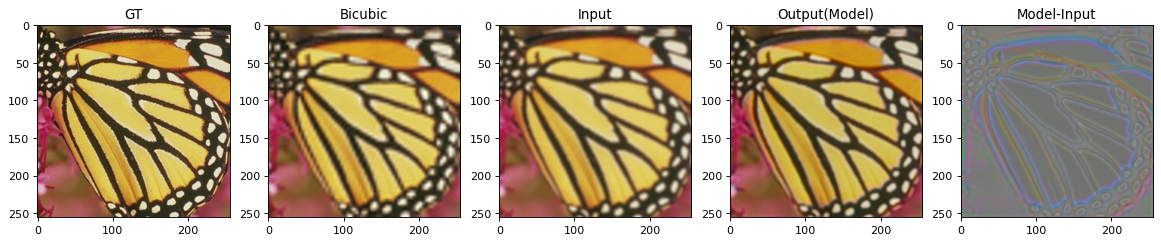

In [67]:
display_PSNR(im_gt, im_b, im_b2, model, channels=1);


In [ ]:
im_gt.size

In [68]:
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, channels=1, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(height/scale), int(width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = Crappify(crop_size = None, kernel_size=scale*2, quality=90)(im_gt)# open image file
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, channels=channels, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 



psnr for bicubic is 45.956321627251995dB
psnr for input is 39.33623253214796dB
psnr for Model is 28.492622997637532dB
PSNR improvement is -10.843609534510428dB
Sharpness Measurement GroundTruth: 247.28295878820063
Sharpness Measurement Bicubic: 138.91155724134296
Sharpness Measurement Input: 261.97689008804446
Sharpness Measurement Model: 314.3475469117984


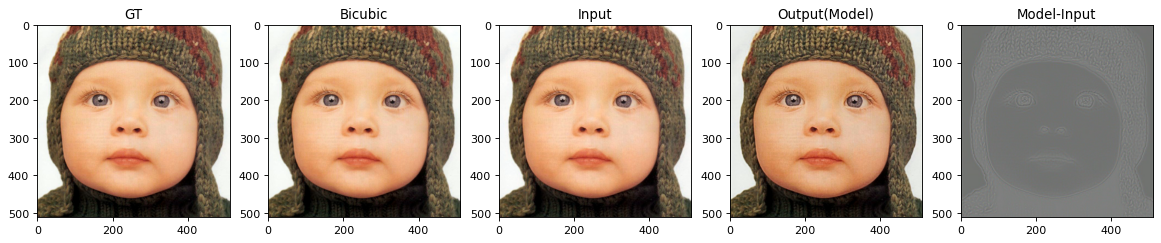

psnr for bicubic is 42.79410768621573dB
psnr for input is 45.0080892162093dB
psnr for Model is 29.25417354652623dB
PSNR improvement is -15.75391566968307dB
Sharpness Measurement GroundTruth: 726.1960912189749
Sharpness Measurement Bicubic: 462.45078151422496
Sharpness Measurement Input: 747.3102962611179
Sharpness Measurement Model: 945.70896309152


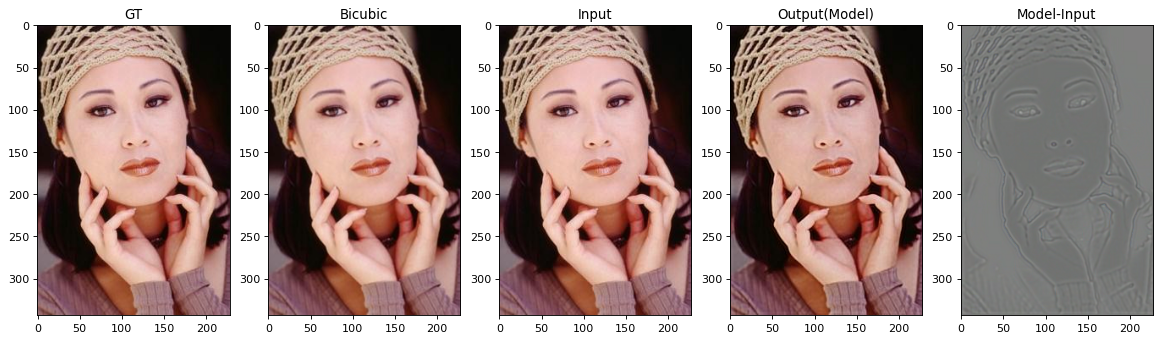

psnr for bicubic is 38.12550760172535dB
psnr for input is 35.408010386670654dB
psnr for Model is 29.390193354430206dB
PSNR improvement is -6.017817032240448dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 1370.7472093096003
Sharpness Measurement Input: 2387.419852766907
Sharpness Measurement Model: 3093.7782780742273


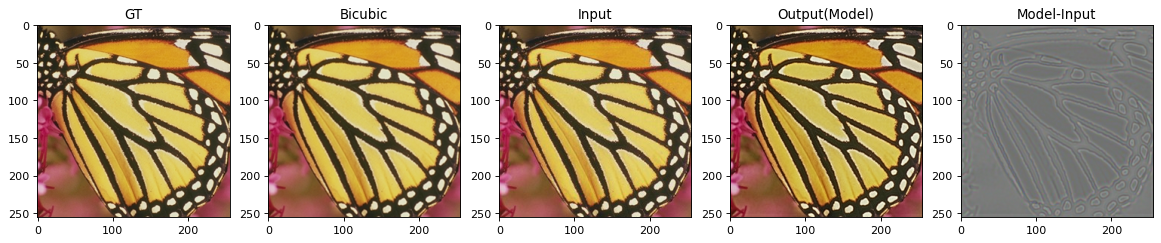

psnr for bicubic is 39.02802708244715dB
psnr for input is 33.97203032156464dB
psnr for Model is 32.05710740519939dB
PSNR improvement is -1.9149229163652493dB
Sharpness Measurement GroundTruth: 593.2631865654935
Sharpness Measurement Bicubic: 218.16163451930836
Sharpness Measurement Input: 624.443998182886
Sharpness Measurement Model: 655.1973752023896


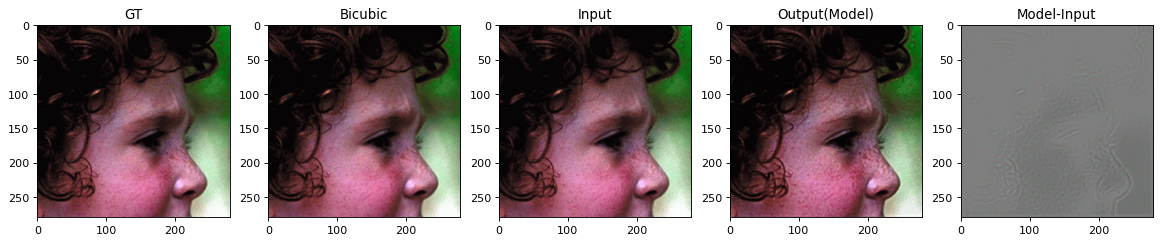

psnr for bicubic is 47.29471743768265dB
psnr for input is 36.400720356447124dB
psnr for Model is 32.43840603801661dB
PSNR improvement is -3.962314318430515dB
Sharpness Measurement GroundTruth: 233.21159694144288
Sharpness Measurement Bicubic: 167.01837064013066
Sharpness Measurement Input: 242.78410186500125
Sharpness Measurement Model: 331.4312971020923


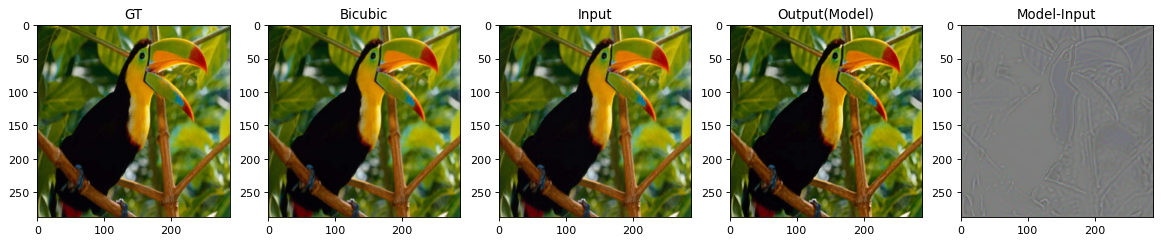

Bicubic average PSNR = 42.63973628706458
Model average PSNR = 30.326500668361994


In [74]:
test_results("/media/SSD/superres/video_data/test_data/Set5", .5, channels = 1,display = True)

# convert sample videos

In [ ]:
result_path

In [ ]:
folder = "/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/"

infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp4(infile, outfile, model,channels=3, factor=1.6,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, model,channels=3, factor=2.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, model,channels=3, factor=3.0,display=False,bitrate= "4000k")


In [ ]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=3, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz/super8hespcn1.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = result_file/"super8long.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=3, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:
dualfile= folder + "super8longdual.mp4"
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}